In [2]:
!pip install groq shap lime pandas matplotlib seaborn scikit-learn transformers nltk dotenv bs4


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import re
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# LLM Integration
from groq import Groq

# NLP and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XAI Libraries
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import json

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

In [59]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
if 'google.colab' in sys.modules:
    from google.colab import userdata
    LLM_API_KEY = userdata.get("GROQ_API_KEY")
    print("Running in Google Colab")
    IN_COLAB = True
else:
    print("Not running in Google Colab")
    LLM_API_KEY = os.getenv("GROQ_API_KEY")
    IN_COLAB = False

Not running in Google Colab


In [60]:
# ============================================================================
# 2. GROQ CLIENT SETUP
# ============================================================================

# Initialize Groq client
MODEL_NAME = "qwen/qwen3-32b"
client = Groq(api_key=LLM_API_KEY)

In [ ]:
def query_llm(prompt: str, model: str, max_retries: int = 3) -> str:
    """Query Qwen3-32B via Groq with retry logic"""
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{
                                "role": "system",
                                "content": "You are a concise assistant. Do NOT output <think> or chain-of-thought. Only final answers."
                          },
                          {
                                "role": "user", 
                                "content": prompt
                          }
                        ],
                temperature=0.0,  # Deterministic for consistency
                max_tokens=2048,
                top_p=1,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
                continue
            else:
                print(f"Error after {max_retries} attempts: {e}")
                return ""

In [62]:
# Additional imports for parallel processing
import multiprocessing as mp
# from concurrent.futures import ProcessPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed
print(f"Available CPU cores: {mp.cpu_count()}")


Available CPU cores: 12


In [63]:
# ============================================================================
# 3. DATA LOADING AND PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("DATA LOADING AND PREPROCESSING")
print("=" * 80)

DATAFILE_NAME= 'Financial-QA-10k-sampled.csv'
DATA_PATH = f'../Datasets/{DATAFILE_NAME}'
if not os.path.exists(DATA_PATH):
    DATA_PATH = f'{DATAFILE_NAME}'  # Colab path
# Load dataset (replace with your actual path)
df = pd.read_csv(DATA_PATH)

OUTPUT_PATH = f'../Outputs/Tree-of-Thought/{MODEL_NAME}_1/'

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

print(f"\n✓ Dataset loaded: {len(df)} records")
print(f"✓ Columns: {list(df.columns)}")


DATA LOADING AND PREPROCESSING

✓ Dataset loaded: 1675 records
✓ Columns: ['question', 'answer', 'context', 'ticker', 'filing', 'word_count']


In [64]:
from bs4 import BeautifulSoup

# Text Cleaning Function
def clean_text(text: str) -> str:
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text.strip()

def clean_html(text: str) -> str:
    """Remove HTML tags and entities."""
    if pd.isna(text):
        return ""

    # Parse HTML and extract text
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Clean up HTML entities
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)
    text = re.sub(r'&#[0-9]+;', ' ', text)

    return text

def clean_special_chars(text: str) -> str:
    """Remove special characters and normalize text."""
    if not text:
        return ""

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove email addresses
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}', ' ', text)

    # Clean excessive whitespace
    text = re.sub(r'\\s+', ' ', text)

    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)

    return text.strip()

def normalize_case(text: str) -> str:
    """Normalize text case while preserving proper nouns."""
    if not text:
        return ""

    # Convert to lowercase but preserve some financial terms
    financial_terms = ['USD', 'CEO', 'CFO', 'SEC', 'GAAP', 'EBITDA', 'ROI', 'IPO', 'NYSE', 'NASDAQ']

    # Temporarily replace financial terms
    temp_replacements = {}
    for i, term in enumerate(financial_terms):
        if term in text:
            placeholder = f"__FINANCIAL_TERM_{i}__"
            temp_replacements[placeholder] = term
            text = text.replace(term, placeholder)

    # Convert to lowercase
    text = text.lower()

    # Restore financial terms
    for placeholder, original in temp_replacements.items():
        text = text.replace(placeholder, original)

    return text

def preprocess(text: str) -> str:
    """Apply all preprocessing steps."""
    # Step 1: Clean HTML
    text = clean_html(text)

    # Step 2: Clean special characters
    text = clean_special_chars(text)

    # Step 3: Normalize case
    text = normalize_case(text)
    return text

In [65]:
# Apply cleaning
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)
df['context'] = df['context'].apply(clean_text)
df['combined_text'] = df['question'] + ' ' + df['answer'] + ' ' + df['context']
df['combined_text'] = df['combined_text'].apply(preprocess)

print("✓ Text cleaning completed")

✓ Text cleaning completed


In [66]:
# ============================================================================
# 4. GROUND TRUTH LABEL GENERATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING GROUND TRUTH LABELS")
print("=" * 80)

# (A) SENTIMENT LABELS - Derived from context
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text: str) -> str:
    """Derive sentiment label using VADER"""
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_true'] = df['context'].apply(get_sentiment_label)
# df['sentiment_true'] = df['context'].apply(get_sentiment_label)
print(f"\n✓ Sentiment labels generated")
print(f"  Distribution: {df['sentiment_true'].value_counts().to_dict()}")

# (B) TOPIC LABELS - Derived from questions
def get_topic_label(question: str) -> str:
    """Extract topic from question using keyword matching"""
    q = question.lower()
    if any(word in q for word in ['revenue', 'sales', 'income', 'profit']):
        return 'Revenue'
    elif any(word in q for word in ['risk', 'threat', 'challenge', 'vulnerability']):
        return 'Risk'
    elif any(word in q for word in ['operation', 'efficiency', 'process', 'performance']):
        return 'Operations'
    elif any(word in q for word in ['legal', 'litigation', 'lawsuit', 'compliance']):
        return 'Legal'
    elif any(word in q for word in ['management', 'executive', 'leadership', 'board']):
        return 'Management'
    else:
        return 'Other'

df['topic_true'] = df['question'].apply(get_topic_label)
print(f"\n✓ Topic labels generated")
print(f"  Distribution: {df['topic_true'].value_counts().to_dict()}")



GENERATING GROUND TRUTH LABELS

✓ Sentiment labels generated
  Distribution: {'Positive': 1134, 'Neutral': 336, 'Negative': 205}

✓ Topic labels generated
  Distribution: {'Other': 1224, 'Revenue': 219, 'Legal': 98, 'Operations': 51, 'Management': 45, 'Risk': 38}


In [78]:
# ============================================================================
# 5. TREE-OF-THOUGHT PROMPT TEMPLATES
# ============================================================================

print("\n" + "=" * 80)
print("TREE-OF-THOUGHT PROMPT DESIGN")
print("=" * 80)

def create_qa_prompt(question: str, context: str) -> str:
    """Tree-of-Thought prompt for Question Answering"""
    return f"""
You are a financial domain expert. Your task is to answer questions only based on the context provided. 
Use a Tree-of-Thought reasoning approach:

1. Identify candidate reasoning paths (branches):
   - Look for sentences or phrases in the context that could contain the answer.  
   - Consider multiple interpretations if a sentence could answer the question in more than one way.

2. Analyze each branch:
   - Summarize the key information from that branch.  
   - Check if it directly answers the question.  
   - Assign a confidence level (high, medium, low) for its relevance.

3. Compare and combine branches:
   - Consider which branch or combination of branches gives the most complete and accurate answer.  
   - If multiple branches contain partial answers, combine them logically.

4. Provide the final concise answer:
   - Only include information found in the context.  
   - Avoid adding assumptions, external knowledge, or unrelated commentary.
   - The final answer should be a single sentence.

You must not overthink. Limit your reasoning to a maximum of 3 short steps.
Avoid exploring multiple hypothetical branches or long tree-of-thought reasoning.
Always give a concise final answer after the 3 steps.

Question: {question}  
Context: {context}

Return the output in the following JSON format exactly:
{{
  "branches": [
    {{"branch": 1, "summary": "...", "confidence": "..."}},
    {{"branch": 2, "summary": "...", "confidence": "..."}},
    {{"branch": 3, "summary": "...", "confidence": "..."}}
  ],
  "final_answer": "..."
}}

Do not include any text outside this JSON.
"""

def create_sentiment_prompt(text: str) -> str:
    """Tree-of-Thought prompt for Sentiment Classification"""
    return f"""You are a financial domain expert. Your task is to determine the sentiment of the given financial text. Use a Tree-of-Thought reasoning approach:

Identify reasoning branches:
- Break the text into key phrases or sentences.
- Consider each phrase as a potential branch that may indicate sentiment.
- For each branch, analyze whether it suggests Positive, Negative, or Neutral sentiment.

Analyze each branch:
- Summarize the reasoning for that branch.
- Assign a confidence level: "high", "medium", or "low".

Combine branches to determine overall sentiment:
- Weigh all branches to select the most appropriate sentiment.
- Only base your conclusion on the text; do not assume external information.

Text: {text}

Return output in strict JSON format with dynamic branches without comments, feedback or any other text:

{{
  "branches": [
    {{"branch": 1, "summary": "...", "confidence": "...", "sentiment": "..."}},
    {{"branch": 2, "summary": "...", "confidence": "...", "sentiment": "..."}},
    ...
  ],
  "final_sentiment": "..."
}}

Do not include any text outside this JSON.
"""

def create_topic_prompt(question: str) -> str:
    """Tree-of-Thought prompt for Topic Detection"""
    return f"""You are a financial domain expert. Your task is to classify the given financial question into exactly one category from the list: [Revenue, Risk, Operations, Legal, Management, Other]. Use a Tree-of-Thought reasoning approach:

Identify reasoning branches:
- Analyze the question for keywords, phrases, or context cues.
- Consider each potential cue as a separate branch that may indicate a category.
- Each branch should propose a likely category.

Analyze each branch:
- Summarize why this branch suggests a particular category. 
- Assign a confidence level: "high", "medium", or "low".

Combine branches to determine the final category:
- Consider all branches and their confidence levels.
- Select the most appropriate category based only on the text of the question.
- The final category should be a single word.

Question: {question}

Return output in strict JSON format with dynamic branches without comments, feedback or any other text:

{{
  "branches": [
    {{"branch": 1, "summary": "...", "confidence": "...", "category": "..."}},
    {{"branch": 2, "summary": "...", "confidence": "...", "category": "..."}},
    ...
  ],
  "final_category": "..."
}}

Do not include any text outside this JSON.

"""

print("✓ Tree-of-Thought prompts designed for all three tasks")


TREE-OF-THOUGHT PROMPT DESIGN
✓ Tree-of-Thought prompts designed for all three tasks


In [68]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================
from IPython.display import clear_output
import time

def exact_match(pred: str, gold: str) -> int:
    """Calculate exact match score"""
    return int(pred.strip().lower() == gold.strip().lower())

def token_f1(pred: str, gold: str) -> float:
    """Calculate token-level F1 score"""
    pred_tokens = set(pred.lower().split())
    gold_tokens = set(gold.lower().split())

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    overlap = len(pred_tokens & gold_tokens)
    if overlap == 0:
        return 0.0

    precision = overlap / len(pred_tokens)
    recall = overlap / len(gold_tokens)

    return 2 * precision * recall / (precision + recall)


In [82]:
# Generate predictions
def extract_final_answer(raw_output: str) -> str:
    no_think = re.sub(r"<think>.*?</think>", "", raw_output, flags=re.DOTALL).strip()
    match = re.search(r"Answer:\s*(.*)", no_think, flags=re.DOTALL)
    if match:
        return match.group(1).strip()
    return no_think.strip()

def generate_qa_predictions_sequential():
    qa_predictions = {"branches": [], "qa_pred": [], "qa_error": []}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating QA Predictions"):
        prompt = create_qa_prompt(row['question'], row['context'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            json_data = extract_final_answer(llm_response)
            data = json.loads(json_data)
            qa_predictions["branches"].append(json.dumps(data["branches"]))
            qa_predictions["qa_pred"].append(data["final_answer"])
            qa_predictions["qa_error"].append(None)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            print(llm_response)
            qa_predictions["branches"].append('[]')
            qa_predictions["qa_error"].append("Error parsing JSON")
            qa_predictions["qa_pred"].append("Answer Not Found")
    return qa_predictions

In [90]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================

print("\n" + "=" * 80)
print("TASK 1: QUESTION ANSWERING")
print("=" * 80)

print("Using sequential generation for Question Answering")
qa_preds = generate_qa_predictions_sequential()

df['qa_pred'] = qa_preds['qa_pred']
df['qa_branches'] = qa_preds['branches']
df['qa_error'] = qa_preds['qa_error']
print(f"\n✓ QA predictions completed")


TASK 1: QUESTION ANSWERING
Using sequential generation for Question Answering


Generating QA Predictions:   2%|▏         | 27/1675 [00:44<1:35:21,  3.47s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know the unique features of Rinvoq and the regions where it's approved. First, I'll look at the context provided.

The context says Rinvoq is an oral, once-daily selective and reversible JAK inhibitor. That's a unique feature right there. So that's one branch. Then it mentions it's approved in North America, EU, and Japan. That's another part of the answer. Are there any other features or regions mentioned? The context doesn't provide more details beyond that. 

I need to check if there are multiple interpretations. The unique features are clearly stated as oral, once-daily, selective, reversible JAK inhibitor. The regions are listed. No ambiguity here. So two branches: one for features, one for regions. Wait, the question combines both features and regions. Maybe split into two branches? Let me see. The answer should include both aspects. The context gives both pie

Generating QA Predictions:   2%|▏         | 33/1675 [00:57<1:12:52,  2.66s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about factors that could change the projected cash flows and estimated fair value of the company's assets. The context provided mentions the company uses a future cash flow approach with significant judgment in several areas.

First, I need to identify the key factors from the context. The context lists future volume, revenue and expense growth rates, changes in working capital use, and the discount rate selection. Each of these elements is a variable in the cash flow projection model. 

Next, I'll break them down into separate branches. The first branch could be future volume changes. If sales volume increases or decreases, that directly affects cash flows. The confidence here is high because volume is a primary driver. 

Second, revenue and expense growth rates. If the company's revenues grow faster than expected or expenses rise more than planned, that would alt

Generating QA Predictions:   2%|▏         | 40/1675 [01:11<1:06:13,  2.43s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know when AbbVie Inc. was incorporated and when it became an independent publicly-traded company. 

First, I'll look at the context provided. The first sentence says, "AbbVie was incorporated in Delaware on April 10, 2012." That clearly answers the incorporation date. The second part of the context mentions that on January 1, 2013, AbbVie became an independent, publicly-traded company due to a distribution by Abbott Laboratories. 

So there are two distinct pieces of information here. The first branch would be about the incorporation date, and the second branch is about becoming publicly traded. There's no third piece of information here, so maybe the third branch is non-existent, but the user wants up to three branches. Wait, the context only has two sentences, each providing one date. So two branches. But the JSON requires three branches. Hmm, maybe I need to chec

Generating QA Predictions:   3%|▎         | 45/1675 [01:30<2:11:43,  4.85s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know how Humira is administered and the autoimmune diseases it treats. 

First, I'll look at the context provided. The first sentence says Humira is administered as a subcutaneous injection. That directly answers the administration part. The second part lists rheumatoid arthritis, psoriatic arthritis, and Crohn's disease. 

I need to check if there are other possible interpretations. The context is pretty straightforward here. No conflicting info. So both parts of the question are covered in the context. 

Now, creating the branches. Branch 1 would be about the administration method. Summary: subcutaneous injection, confidence high. Branch 2 covers the diseases listed, also high confidence. Maybe a third branch if there's more, but the context only mentions those three. 

Combine the two branches into the final answer. Make sure to mention both parts and list the di

Generating QA Predictions:   3%|▎         | 50/1675 [01:39<1:13:58,  2.73s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the two approvals needed from the FDA before a clinical trial can start. The context provided mentions that a study sponsor must get approval for their IDE from the FDA and also approval from the Institutional Review Board (IRB). 

First, I need to identify the relevant parts of the context. The first part is clear: FDA approval for the IDE. The second part is about IRB approval. But wait, the question specifically asks for approvals from the FDA. The IRB is mentioned as overseeing the trial, but it's not the FDA. So maybe there's a misunderstanding here.

Looking again, the context says the sponsor must obtain two approvals: one from the FDA for the IDE and another from the IRB. However, the user is asking for the two FDA approvals. The context only mentions one FDA approval (IDE) and one IRB approval. That might mean there's a mistake in the context or perh

Generating QA Predictions:   5%|▍         | 83/1675 [02:35<1:16:27,  2.88s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the responsibility of AMC Entertainment Holdings, Inc.'s management regarding internal control over financial reporting. The context provided is a single sentence: "Management is responsible for establishing and maintaining adequate internal control over financial reporting for the Company as defined in Rule 13a-15f of the Exchange Act."

First, I need to identify the candidate reasoning paths. The context directly states the responsibility, so that's the main branch. There's only one sentence here, so maybe only one branch. But the user wants up to three branches. Hmm, maybe there's an interpretation aspect. Let me check the instructions again. The user said to consider multiple interpretations if a sentence could answer in more than one way. However, this sentence seems straightforward. The responsibility is to establish and maintain adequate internal contr

Generating QA Predictions:   9%|▊         | 146/1675 [04:33<2:00:33,  4.73s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what services AWS offers. The context provided mentions a list of services. First, I need to identify the key parts of the context.

Looking at the context, the main sentence is: "Amazon Web Services AWS offers a broad range of on-demand technology services like compute, storage, database, analytics, and machine learning to developers and enterprises..." So the services listed here are compute, storage, database, analytics, and machine learning. 

Now, I need to check if there are other parts of the context that might mention more services. The rest of the sentence talks about the clients (developers, enterprises, start-ups, etc.), but not additional services. So the main services are those five. 

Next, I should create branches for each service mentioned. Each service is a separate branch. The confidence for each would be high since they are explicitly listed. 

W

Generating QA Predictions:   9%|▉         | 148/1675 [04:39<1:41:04,  3.97s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the expected influences on AWS revenue growth rates given the current macroeconomic environment. The context provided mentions two factors: the current macroeconomic environment and enterprise customer cost optimization efforts.

First, I need to identify the branches. The context has two main elements here. The first is the macroeconomic environment itself, which could include things like inflation, interest rates, or economic downturns. The second is the cost optimization efforts by enterprise customers, which might lead them to reduce spending on cloud services. 

For branch 1, the macroeconomic environment's impact. The summary would be that the current economic conditions are expected to affect AWS revenue growth. Confidence is high because the context directly states this. 

Branch 2 is about enterprise cost optimization. The summary here is that these 

Generating QA Predictions:  12%|█▏        | 205/1675 [06:12<58:03,  2.37s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking how after-tax return on invested capital is defined and calculated for fiscal 2019. The context provided gives two key points.

First, the definition: after-tax return on invested capital is after-tax operating profit (excluding rent charges) divided by invested capital, which includes a factor to capitalize leases. That's the general formula. 

Then, for fiscal 2019 specifically, there's an adjustment mentioned. The after-tax operating profit was adjusted for the impact of the average revaluation of deferred tax liabilities, net of repatriation tax. So the 2019 calculation includes this adjustment.

I need to make sure I separate the general definition from the specific 2019 adjustment. The user wants both the definition and the calculation method for 2019. Let me check if there are other parts in the context that might be relevant. The context seems concise, so t

Generating QA Predictions:  13%|█▎        | 225/1675 [06:52<1:12:33,  3.00s/it]

Error parsing JSON: Expecting ',' delimiter: line 4 column 17 (char 217)
<think>
Okay, let's tackle this question. The user is asking about the primary risks retained under self-insurance by the company. The context provided mentions that Self-Insurance Reserves retain a significant portion of the risks associated with workers compensation, general, product liability, property, and vehicle liability.

First, I need to identify the candidate reasoning paths. The key sentence here is the one listing the types of risks. Each of these could be a branch. Let me check if there are multiple interpretations. The context seems straightforward, listing five specific risk categories. 

Next, analyzing each branch. Each risk type mentioned (workers compensation, general, product liability, property, vehicle liability) is a separate risk retained. The confidence for each would be high since they are explicitly listed. However, the user is asking for the primary risks, so combining all into one bran

Generating QA Predictions:  17%|█▋        | 278/1675 [08:17<58:39,  2.52s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking where Caterpillar Insurance Co. Ltd. is domiciled and under what regulatory authority it operates. 

First, I need to look at the context provided. The context says, "Caterpillar Insurance Co. Ltd., a wholly owned subsidiary of Caterpillar Insurance Holdings Inc., is a captive insurance company domiciled in Bermuda and regulated by the Bermuda Monetary Authority." 

So, the key parts here are "domiciled in Bermuda" and "regulated by the Bermuda Monetary Authority." There's only one sentence here, but it contains both pieces of information needed. 

For the branches, I can split this into two parts: one about the domicile and another about the regulatory authority. But since they're in the same sentence, maybe they're part of the same branch. However, the user wants up to three branches. Let me check the instructions again. The example shows three branches, but mayb

Generating QA Predictions:  20%|██        | 343/1675 [10:18<1:22:17,  3.71s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about regulations on commercial content during children's programming on cable and broadcast networks. The context provided mentions federal regulations limiting the amount of commercial content during programming made for kids 12 and under.

First, I need to identify the candidate branches. The context is a single sentence, so there's only one branch here. The key points are federal regulations, limitation on commercial content, and the target audience being children 12 and under. 

Next, analyzing this branch: the summary would be that federal regulations limit commercial content during children's programming. The confidence is high because the context directly states this. There's no ambiguity here, so no need for multiple interpretations. 

Since there's only one branch, the final answer combines that information. The answer should mention the federal regulatio

Generating QA Predictions:  21%|██        | 344/1675 [10:23<1:31:32,  4.13s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the factors considered in the qualitative assessment of the estimated fair values of cable franchise rights. The context provided mentions several factors.

First, I need to identify the key elements in the context. The sentence lists changes in projected future cash flows, recent market transactions, macroeconomic conditions, discount rates, and changes in market capitalization. Each of these seems like a separate factor. 

Next, I should check if each of these points directly answers the question. The question is about qualitative assessment factors, and all the listed items are factors that would influence the fair value assessment. Each of these can be considered a separate branch. 

Now, assigning confidence levels. Since the context explicitly lists these factors, each has high confidence. There's no ambiguity here; the factors are clearly mentioned. 



Generating QA Predictions:  21%|██        | 348/1675 [10:31<1:00:30,  2.74s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the primary revenue source for Comcast's Theme Parks segment. The context provided says that revenue is primarily from guest spending, including ticket sales and in-park spending on food, beverages, and merchandise.

First, I need to identify the candidate branches. The key sentence here is the one mentioning revenue sources. The main points are ticket sales and in-park spending. So, two branches: one for ticket sales and another for in-park spending. Wait, but the question asks for the primary source. The context says "primarily derived from guest spending... including ticket sales and in-park spending..." So maybe the primary is guest spending, which includes both tickets and in-park. But the user might be looking for the specific components. Hmm.

Wait, the context states that the primary source is guest spending, which includes ticket sales and in-park sp

Generating QA Predictions:  21%|██▏       | 356/1675 [10:47<1:00:11,  2.74s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for Chipotle's employment numbers at the end of 2023 and how the company views its employee relationships.

First, I'll look at the context provided. The context says, "As of December 31, 2023, Chipotle employed 116,068 people worldwide and believes its relationship with employees is good." 

Breaking this down, the first part gives the exact number of employees as of the close of 2023. That directly answers the first part of the question. The second part mentions the company's belief about employee relationships being good, which answers the second part. 

I need to check if there are any other possible interpretations. The sentence is straightforward with two clear pieces of information. There's no ambiguity here. So, each part of the question is addressed by a separate part of the context. 

For the branches, the first branch would be the employment number, and 

Generating QA Predictions:  21%|██▏       | 359/1675 [10:53<54:16,  2.47s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know Chipotle's key strategies for business growth as discussed in their strategy. The context provided mentions five key fundamental strategies. I need to extract each of these strategies and present them as separate branches.

First, I'll look at the context sentence: "Our mission is to win today while we grow our future by focusing on five key fundamental strategies Sustaining world class people leadership, running successful restaurants, making the brand visible and loved, amplifying technology and innovation, and expanding access and convenience."

Breaking this down, the five strategies are listed after the colon. Each is a separate point. Let me list them out:

1. Sustaining world class people leadership
2. Running successful restaurants
3. Making the brand visible and loved
4. Amplifying technology and innovation
5. Expanding access and convenience

Now, the

Generating QA Predictions:  22%|██▏       | 373/1675 [11:14<34:55,  1.61s/it]

Error parsing JSON: Expecting ',' delimiter: line 5 column 17 (char 300)
<think>
Okay, let's tackle this question. The user is asking for the key finding from the Talent Management Equity Audit at Chipotle as reported by the consultant.

First, I need to look at the context provided. The context says the consultant concluded that Chipotle has a robust set of processes, practices, and policies for equitable talent recruiting, development, and retention. They also identified opportunities to strengthen existing practices.

Now, breaking this down into branches. The first part of the context mentions the robust processes. That's a key point. The second part talks about opportunities for improvement. Are there other possible interpretations? Maybe, but the main findings are these two points. 

For branch 1, the summary would be the robust processes and their areas (recruiting, development, retention). Confidence is high because it's directly stated. Branch 2 is the identified opportunities

Generating QA Predictions:  25%|██▌       | 419/1675 [12:42<58:50,  2.81s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for the weighted average remaining lease terms for operating and finance leases as of January 31, 2023. 

First, I need to look at the context provided. The context states: "As of January 31, 2023, the weighted average remaining lease term for operating leases was 7 years and for finance leases was 3 years." That seems straightforward.

Now, breaking it down into branches. The context has two separate pieces of information here. The first part mentions operating leases with 7 years, and the second part is about finance leases with 3 years. Each of these can be a separate branch since they answer different parts of the question.

For branch 1, the summary would be the operating lease term. The confidence is high because it's directly stated. Branch 2 is the finance lease term, also directly stated, so high confidence. There's no third piece of information here, so m

Generating QA Predictions:  29%|██▉       | 482/1675 [14:34<46:27,  2.34s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking how changes in key assumptions affect the determination of fair values of assets. The context provided mentions that changes in assumptions like discount rate or projected future revenues, expenses, and cash flows could materially affect fair values.

First, I need to identify the candidate reasoning paths. The context directly states that changes in these key assumptions can have a material impact. So the main branch here is the effect of altering these assumptions on fair value calculations. There's one main point here, but maybe I can split it into two branches if there are different aspects. However, the context groups them together, so maybe just one branch. Wait, the question is about "how" the change affects the determination. The context says it could "materially affect," which implies a significant impact. 

Next, analyzing the branch: the key info is that

Generating QA Predictions:  29%|██▉       | 484/1675 [14:43<1:17:32,  3.91s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know Mike Spanos's previous roles before becoming COO of Delta in June 2023. The context provided mentions two roles: President and CEO of Six Flags Entertainment Corporation and CEO for PepsiCo in the Asia, Middle East, and North Africa regions.

First, I need to identify the candidate branches. The context has two distinct roles, so each can be a separate branch. Branch 1 is his role at Six Flags, and Branch 2 is his role at PepsiCo. There's no mention of a third role here, so maybe only two branches. Wait, the user asked for previous roles, and the context lists two. So each of these is a separate branch. 

Next, analyze each branch. For Branch 1, the summary would be his position as President and CEO of Six Flags. The confidence is high because it's directly stated. For Branch 2, his role as CEO for PepsiCo in specific regions is also directly mentioned, so high

Generating QA Predictions:  31%|███       | 513/1675 [15:35<32:50,  1.70s/it]  

Error parsing JSON: Expecting ',' delimiter: line 5 column 17 (char 286)
<think>
Okay, let's tackle this question. The user is asking about the approach used to estimate the fair value of the Family Dollar trade name intangible asset. The context provided says, "We estimate the fair value of our trade name intangible asset based on an income approach using the relief-from-royalty method."

First, I need to identify the key parts here. The main sentence mentions two things: the income approach and the relief-from-royalty method. The question is specifically about the approach, so the answer should include both the income approach and the relief-from-royalty method as the specific technique used under that approach.

Now, considering the Tree-of-Thought steps. The first step is to look for candidate reasoning paths. The context has one sentence, so there's only one branch here. The income approach is the primary method, and the relief-from-royalty is the specific method within that appro

Generating QA Predictions:  31%|███       | 519/1675 [15:49<47:11,  2.45s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the changes in the selling, general, and administrative expense rate from 2021 to 2022. The context provided mentions that the rate increased from 20.9 in 2021 to 23.4 in 2022. The reason given is a 95 basis point increase due to factors like asset impairments, legal fees, and inflation.

First, I need to identify the key numbers here. The rate went up by 2.5 points (23.4 - 20.9). The context also specifies that the increase was 95 basis points. Wait, basis points are different from percentage points. One basis point is 0.01, so 95 basis points would be 0.95 percentage points. But the actual numerical increase here is 2.5 points. Hmm, maybe there's a discrepancy here. But the context says the increase is 95 basis points, which is 0.95%, but the numbers given are 20.9 to 23.4, which is a 2.5 percentage point increase. That seems conflicting. Wait, maybe the 95

Generating QA Predictions:  32%|███▏      | 538/1675 [16:22<1:11:17,  3.76s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking how the 21st Century Cures Act affected patient access to Medicare Advantage plans. The context provided says that the Act broadened access to certain enhanced benefits offered by these plans, which increased the percentage of patients on them.

First, I need to identify the key points in the context. The main action here is "broadened patient access to certain enhanced benefits." So the first branch would be about expanding access to these benefits. The confidence here is high because the context directly states this.

Next, the context mentions that this action led to an increase in the percentage of patients on these plans. That's a direct effect, so the second branch would focus on the increase in patient numbers. Confidence is also high here since it's explicitly stated.

I need to check if there are other possible interpretations. The question is about patien

Generating QA Predictions:  33%|███▎      | 545/1675 [16:37<53:59,  2.87s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what the No Surprises Act requires providers to develop and disclose. The context given mentions that under the Act, providers like DaVita must create and disclose a Good Faith Estimate detailing expected charges for certain items or services.

First, I need to identify the key parts of the context. The main sentence here is about developing and disclosing a Good Faith Estimate. That seems directly relevant. There's only one mention here, so maybe there's only one branch. But the instructions say to consider multiple interpretations if possible. However, in this case, the sentence is pretty straightforward. The Good Faith Estimate is the answer here. 

Next, analyzing the branch: the summary would be that providers must develop and disclose a Good Faith Estimate. The confidence is high because the context explicitly states this. There's no ambiguity in the sentence

Generating QA Predictions:  33%|███▎      | 558/1675 [16:59<46:05,  2.48s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the factors that caused the decline in net cash from operating activities in fiscal year 2023. The context provided says it declined primarily due to lower cash receipts and higher personnel-related payments.

First, I need to identify the branches. The context mentions two factors: lower cash receipts and higher personnel payments. Each of these can be a separate branch. 

For branch 1, the summary would be lower cash receipts. The confidence here is high because the context directly states this as a primary reason. 

Branch 2 is higher personnel-related payments. Similarly, the context lists this as a main factor, so confidence is also high. 

There's no third factor mentioned in the context, so branch 3 would be irrelevant. But the JSON requires three branches. Wait, maybe I missed something. Let me check again. The context only mentions two factors. The u

Generating QA Predictions:  34%|███▍      | 577/1675 [17:41<49:19,  2.70s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the categories eBay focused on in 2023 and how they contributed to GMV.

First, I need to look at the context provided. The context says, "We derived a majority of GMV in 2023 from the following product categories parts accessories, collectibles, fashion, electronics, and home garden." 

So the main point here is the list of categories. The key words are "majority of GMV" and the specific categories mentioned. The user wants to know both the categories and their contribution to GMV. 

The context directly lists the categories and states that they contributed to the majority of GMV. There's no ambiguity here. The categories are parts accessories, collectibles, fashion, electronics, and home garden. The contribution is that they made up the majority of the GMV. 

I need to check if there are multiple interpretations. The sentence is straightforward, so there's 

Generating QA Predictions:  37%|███▋      | 612/1675 [18:44<57:42,  3.26s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what actions the Australian Securities and Investments Commission (ASIC) can take against individuals involved in corporations. The context provided says that ASIC regulates corporations and has authority to investigate, prosecute, ban individuals, and seek civil penalties.

First, I need to identify the possible actions from the context. The key phrases here are "investigate," "prosecute," "ban individuals," and "seek civil penalties." Each of these is a separate action. 

Next, I'll analyze each branch. The first action is investigation. The context directly mentions this, so that's a high confidence. Prosecution is another action mentioned, so that's also high. Banning individuals is explicitly stated, so high confidence again. Seeking civil penalties is another direct action from the context. Wait, the context lists four actions: investigate, prosecute, ban, an

Generating QA Predictions:  37%|███▋      | 620/1675 [19:01<48:54,  2.78s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the sources of liquidity for the company as of December 31, 2023. The context provided mentions several things: existing cash balance, liquidity from CP and Revolver, cash from operations, and access to debt markets.

First, I need to identify each possible source. The context lists four items. Let me check each one. The existing cash balance is a direct source. Then there's liquidity from CP (Commercial Paper) and Revolver (which is a type of credit facility). Cash generated from operations is another source, and continued access to public or private debt markets. 

Each of these seems like a separate branch. The confidence for each should be high since they are all explicitly mentioned. Now, I need to summarize each branch concisely. The final answer should combine all these points without adding anything else. Let me make sure I don't miss any of the four 

Generating QA Predictions:  39%|███▊      | 648/1675 [19:45<51:52,  3.03s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the typical warranty terms for microinverter units based on their generation, as stated in the company's financial statements.

First, I need to look at the context provided. The context says, "The warranty term related to microinverter units is typically 15 years for first and second generation microinverters and up to 25 years for subsequent generation microinverters." 

So, the key points here are the different warranty periods for different generations. The first and second generations have a 15-year warranty, while later ones have up to 25 years. 

Now, I need to break this down into branches. The first branch would be about the first and second generation having 15 years. The second branch is the subsequent generations with 25 years. There's only two parts here, but the user asked for three branches. Hmm, maybe I can split the first part into two? Wait,

Generating QA Predictions:  41%|████      | 686/1675 [20:52<46:19,  2.81s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what caused the deterioration in Corporate Others EBIT from 2022 to 2023. The context provided mentions a significant drop from a positive 748 million to a loss of 760 million. 

First, I need to identify the key factors mentioned. The context states that the EBIT deterioration was driven by lower past service pension and OPEB income. That's a major point. Then it says it's partially offset by higher interest income from Ford Credit due to higher interest rates. 

So, the main reason is the decrease in pension and OPEB income. The offsetting factor is the increased interest income, but since it's only partial, the overall EBIT still deteriorated. 

I should check if there are other factors mentioned. The context doesn't mention anything else, so those two points are the main branches. The first branch is the primary driver, the second is the partial offset. Maybe a

Generating QA Predictions:  42%|████▏     | 708/1675 [21:27<44:54,  2.79s/it]

Error parsing JSON: Expecting property name enclosed in double quotes: line 5 column 102 (char 457)
<think>
Okay, let's tackle this question. The user is asking about the primary responsibilities of FedEx Trade Networks Transport Brokerage. The context provided mentions a few key services they offer.

First, I need to identify the main points. The context states they provide international trade services, specializing in customs brokerage, global ocean and air freight forwarding, and managed transportation. That's the first part. Then, there's additional info about customs clearance services for FedEx Express at major U.S. hubs and border customs clearance for FedEx Ground and FedEx Freight.

So, breaking it down into branches. The first branch would be their core services: customs brokerage, ocean and air freight, managed transportation. The second branch is the customs clearance for FedEx Express. The third is the border customs clearance for Ground and Freight. Each of these is a sep

Generating QA Predictions:  43%|████▎     | 719/1675 [21:51<1:00:01,  3.77s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the factors that influenced FedEx Express's decision to retire certain aircraft and engines in 2023. The context provided mentions that decisions to remove long-lived assets from service are based on projections of reduced capacity needs or lower operating costs from newer aircraft types, which might result in impairment charges.

First, I need to identify the key points in the context. The main factors mentioned are reduced capacity needs and lower operating costs of newer aircraft. These are the two primary reasons given for retiring assets. There's also a mention of impairment charges as a possible outcome, but that's more of a financial consequence rather than a factor in the decision-making process.

Next, I'll analyze each branch. The first branch would be reduced capacity needs. This makes sense because if FedEx doesn't need as much capacity, they migh

Generating QA Predictions:  43%|████▎     | 726/1675 [22:05<37:54,  2.40s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the challenges Gilead faces in forecasting product sales. The context provided mentions two main things: difficulties in predicting demand and fluctuations in purchasing patterns or wholesaler inventories.

First, I need to identify the branches. The context has two key points. The first is predicting demand, which is a common challenge in sales forecasting. The second is fluctuations in purchasing patterns and wholesaler inventories. These are separate but related issues. 

For branch 1, the summary would be about the difficulty in predicting demand. That's straightforward. The confidence here is high because the context directly states this as a challenge. 

Branch 2 would focus on fluctuations in purchasing patterns and wholesaler inventories. Again, the context explicitly mentions these as factors, so confidence is also high. 

There's no third point in t

Generating QA Predictions:  48%|████▊     | 809/1675 [24:08<35:21,  2.45s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about technological advancements Google has introduced to improve search functionality. The context provided mentions two main things: new search modalities like voice and visual search, and multisearch which allows text and image searches simultaneously.

First, I need to identify the branches. The first sentence talks about voice and visual search. That's one advancement. The second part mentions multisearch. So two branches here. The third branch might be a combination or another point, but the context doesn't mention more. Wait, the user said to consider up to three branches, but maybe there's only two here. Let me check again.

The context says "new search modalities, like voice and visual search" – that's one branch. Then "multisearch, which lets people search with text and images at the same time" – that's another. Are there any other points? The first part 

Generating QA Predictions:  51%|█████     | 857/1675 [25:25<29:01,  2.13s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the Bank of England's expectations for certain UK financial institutions under the UK Resolution Assessment Framework.

First, I need to look at the context provided. The key sentence is: "Certain U.K. financial institutions, including GSI and GSIB, are required to meet the Bank of England's expectations contained in the U.K. Resolution Assessment Framework, including with respect to loss absorbency, contractual stays, operational continuity and funding in resolution."

So, the context mentions four specific areas: loss absorbency, contractual stays, operational continuity, and funding in resolution. These are the expectations the Bank of England has for these institutions. 

Now, I need to break this down into branches. Each of these four areas can be a separate branch. But the user asked for a maximum of three branches. Hmm, maybe combine some? Wait, the ex

Generating QA Predictions:  53%|█████▎    | 892/1675 [26:21<40:44,  3.12s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know the factors that impact revenue estimates for film and TV programs. The context provided lists four factors. I need to break them down into branches.

First, the context mentions historical performance of similar films and TV shows. That's a clear factor, so that's branch 1. High confidence since it's directly stated.

Next, expected distribution platforms. Different platforms like streaming vs. theaters can affect revenue. That's branch 2, also high confidence.

Then, factors unique to the content. This could include things like the script, cast, or production quality. Branch 3, high confidence again.

Lastly, success of related merchandise like toys and games. That's another revenue stream tied to the program's success. Branch 4, but wait, the user asked for three branches. Oh, the context lists four factors. Hmm, the user's example JSON has three branches. M

Generating QA Predictions:  55%|█████▌    | 925/1675 [27:11<30:09,  2.41s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what type of products The Home Depot provides. The context given lists several categories. First, I need to identify each category mentioned.

Looking at the context: building materials, home improvement products, lawn and garden products, décor products, and facilities maintenance, repair and operations products. Each of these is a separate category. 

Now, I need to check if each of these directly answers the question. The question is about the types of products, so each listed category is a valid answer. Since there are five distinct categories, but the user wants up to three branches, I should pick the most relevant ones. However, the context lists five, so maybe combine some if needed. Wait, the user said to consider multiple interpretations if a sentence could answer in more than one way. But here, each category is distinct. 

Wait, the example in the problem

Generating QA Predictions:  56%|█████▌    | 932/1675 [27:23<28:42,  2.32s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the types of insurance coverage the company provides for employees. The context mentions two main things: workers compensation or equivalent coverage for all employees, and self-insured health coverage for some U.S. and Puerto Rico employees with third-party protection for costs over thresholds.

First, I need to identify the branches. The first sentence clearly states workers compensation, which is a type of insurance. That's one branch. The second part talks about health coverage being self-insured but with third-party insurance for costs over certain amounts. That's another branch. Are there any other possible branches? Maybe the mention of Puerto Rico, but that's part of the health coverage detail, not a separate type. 

For each branch, summarize the key info. Workers comp is straightforward. The health coverage is self-insured but with third-party cover

Generating QA Predictions:  56%|█████▌    | 940/1675 [27:41<34:10,  2.79s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about methodologies used to determine the fair value of an asset group when it's not recoverable. The context provided lists several methods.

First, I need to identify the candidate branches. The context mentions discounted cash flow models, appraisals, comparison to recent transactions, and current estimated net sales proceeds from pending offers. Each of these is a separate methodology, so each can be a branch.

Next, analyze each branch. The first one is discounted cash flow models. That's a common method in finance for valuing assets based on future cash flows. The summary would be straightforward. Confidence is high because it's explicitly listed. 

Appraisals are another method. They involve professional valuation, so that's a valid point. Confidence is also high here. 

Comparison to recent transactions is a market approach, using similar sales data. High c

Generating QA Predictions:  56%|█████▌    | 942/1675 [27:48<40:04,  3.28s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the criteria for accruing an estimated loss from a legal contingency. The context provided says it's based on the probability of an unfavorable outcome and the ability to make a reasonable estimate of the loss amount.

First, I need to identify the branches. The context mentions two main criteria: probability of an unfavorable outcome and capability to estimate the loss. These are two separate points, so each can be a branch. 

For branch 1, the summary would be about the probability of an unfavorable outcome. The confidence here is high because the context directly states this as a criterion. 

Branch 2 would focus on the capability to make a reasonable estimate. Again, the context clearly mentions this, so confidence is high. 

There's no third branch because the context only provides these two criteria. The other branches would be empty, but since the user

Generating QA Predictions:  56%|█████▋    | 943/1675 [27:53<46:32,  3.81s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the year-over-year changes in occupancy and ADR at the end of 2023. The context provided says that for the year ended December 31, 2023, occupancy increased by 4.6 percentage points and ADR rose by 5.4 percent compared to the previous year.

First, I need to identify the branches. The context has two main pieces of information: occupancy and ADR. Each is a separate data point, so they can be considered as two branches. There's no mention of any other factors or potential interpretations here, so maybe only two branches. Wait, the user might expect three branches, but the context only provides two data points. Hmm, the JSON requires three branches. Maybe I need to check if there's a third part, but the context only mentions two metrics. Perhaps the third branch is non-existent, but the JSON structure requires three. Wait, the instructions say to consider multi

Generating QA Predictions:  57%|█████▋    | 948/1675 [28:04<34:48,  2.87s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the conditions under which Hilton can terminate a franchise contract. The context provided mentions two main things: nonpayment of fees and noncompliance with brand standards.

First, I need to identify the branches. The context gives two specific events of default. Each of these can be a separate branch. So, branch 1 is nonpayment of fees, and branch 2 is noncompliance with brand standards. There's no third condition mentioned, so maybe the third branch is just a placeholder with low confidence or not applicable. But the user wants exactly three branches. Hmm, maybe there's an implied third one like other specified events, but the context doesn't specify. So perhaps the third branch is a low confidence one based on the phrase "specified events of default" which might include other unspecified reasons. But the context only lists two. 

For confidence levels, 

Generating QA Predictions:  57%|█████▋    | 949/1675 [28:08<41:26,  3.42s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what types of risks are covered by the company's insurance policies. The context provided mentions the company has insurance for general liability, property, business interruption, terrorism, and other risks related to their business for all owned and leased hotels.

First, I need to identify the candidate branches. The context lists several specific types of insurance: general liability, property, business interruption, terrorism, and "other risks." Each of these could be a separate branch. 

For branch 1, general liability is explicitly mentioned. That's a clear risk covered. Confidence is high here. Branch 2 would be property insurance, which is also directly stated, so high confidence. Branch 3 is business interruption, again directly listed, high confidence. Then there's terrorism, which is another specific risk mentioned. But the user might consider "other ri

Generating QA Predictions:  59%|█████▊    | 981/1675 [29:07<25:58,  2.25s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for the aggregate projected benefit obligations for both U.S. and Non-U.S. Defined Benefit Plans as of October 31, 2022, and 2023.

First, I need to look through the provided context. The context has two sentences. The first sentence gives the numbers for 2022: 289 million for U.S. plans and 996 million for Non-U.S. The second sentence provides the 2023 figures: 267 million for U.S. and 1,052 million for Non-U.S. 

So, there are two distinct time points here. Each year's data is a separate branch. The user wants both years for both regions. The first branch would cover 2022 data, the second 2023. The third branch isn't needed here since there's only two data points. Wait, the JSON requires three branches. Hmm, maybe I need to split the U.S. and Non-U.S. for each year. Let me check the context again. The context mentions both U.S. and Non-U.S. in each year's sentenc

Generating QA Predictions:  60%|█████▉    | 1003/1675 [29:45<28:18,  2.53s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about Hershey's acquisitions to expand their snacking portfolio and the dates they occurred. The context provided mentions two acquisitions: Pretzels Inc. in December 2021 and Dots and Weaver in 2022.

First, I need to identify the branches. The first sentence talks about Pretzels Inc. acquired in December 2021. The second part mentions Dots and Weaver in 2022. Each of these is a separate acquisition, so they should be separate branches. 

For branch 1, the summary would be the acquisition of Pretzels Inc. in December 2021. Confidence is high because it's clearly stated. Branch 2 is Dots and Weaver in 2022, also high confidence. There's no third acquisition mentioned, so maybe a third branch isn't needed, but the user wants up to three. Wait, the context only lists two acquisitions. So maybe the third branch is non-existent, but the JSON requires three branches. Hm

Generating QA Predictions:  60%|██████    | 1012/1675 [30:04<27:58,  2.53s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know what factors contributed to the increase in operating profit in 2023. The context provided says that operating profit went up from 2,260.8 million in 2022 to 2,560.9 million in 2023, which is a 13.3% rise. The main reason given is higher gross profit, but it's partially offset by higher SMA expenses.

First, I need to identify the key factors mentioned. The context directly states that the increase was "predominantly due to higher gross profit." So that's one factor. Then it mentions that this was "partially offset by higher SMA expenses." Wait, but the question is about factors that contributed to the increase. The higher SMA expenses are actually a negative factor, but they are offsetting the positive effect of higher gross profit. So the main contributing factor is the higher gross profit. The SMA expenses are a counteracting factor but not a contributor to 

Generating QA Predictions:  62%|██████▏   | 1041/1675 [30:51<22:19,  2.11s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the types of alternative work styles the company offers. The context provided mentions "alternative work styles, such as home, hybrid home, office, hybrid office, and field." 

First, I need to identify the candidate branches. The context lists several options separated by commas. Each of these is a distinct work style. The first branch would be home, the second hybrid home, third office, fourth hybrid office, and fifth field. But the user wants up to three branches. Wait, the example in the problem shows three branches. Hmm, maybe the user expects three, but the context lists five. But the instructions say to use a maximum of three short steps. Wait, the JSON requires three branches. So perhaps the user wants the first three, but the context lists five. Wait, the context says "home, hybrid home, office, hybrid office, and field." So five types. But the JSON 

Generating QA Predictions:  64%|██████▎   | 1064/1675 [31:28<25:49,  2.54s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the key priorities in the cybersecurity strategy from the given context.

First, I need to identify the relevant parts of the context. The context mentions the Cybersecurity Strategy outlines key priorities and methods, including assessing risk, prioritizing testing, identifying remedial actions, and validating improvements. These four points seem to be the main priorities.

Next, I'll break them down into separate branches. Each of these phrases could be a branch. Assessing risk is one, prioritizing testing another, identifying remedial actions third, and validating improvements fourth. But the user wants a maximum of three branches. Hmm, maybe combine some? Wait, the example in the problem had three branches even if there were four points. Let me check the context again. The context lists four actions: assessing risk, prioritizing testing, identifying remed

Generating QA Predictions:  66%|██████▌   | 1102/1675 [32:43<44:21,  4.64s/it]

Error parsing JSON: Unterminated string starting at: line 4 column 6 (char 169)
<think>
Okay, let's tackle this question. The user wants to know what factors contributed to the increase in Iron Mountain's storage rental revenue in 2023. The context provided mentions two main reasons: organic growth from increased volume in faster-growing markets and revenue management in the Global Data Center Business segment.

First, I need to identify the branches. The context has two key factors. The first is organic growth driven by increased volume in faster-growing markets. The second is revenue management in the Global Data Center segment. There's no mention of a third factor, so maybe only two branches. But the JSON requires three branches. Hmm, maybe I can split the first one into two parts? Wait, the context says "increased volume in faster growing markets and revenue management..." which are two separate points. So branch 1: organic growth from increased volume in faster-growing markets. Br

Generating QA Predictions:  71%|███████   | 1181/1675 [34:47<27:41,  3.36s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for two numbers: the gross amount of unrecognized tax benefits as of December 31, 2023, and the net benefit if the company wins all uncertain tax positions.

First, I'll look at the context provided. The first sentence says, "As of December 31, 2023, the gross amount of unrecognized tax benefits was 929 million." That seems straightforward. That's the first part of the answer. 

Next, the second part of the question is about the net benefit if the company prevails on all uncertain tax positions. The context states, "If the Company were to prevail on all uncertain tax positions, the net effect would be a benefit of 632 million, exclusive of any benefits related to interest and penalties." So that's the second number. 

I need to check if there are any other parts of the context that might relate to these numbers. The context is short, so there's not much else. The k

Generating QA Predictions:  73%|███████▎  | 1230/1675 [35:55<18:16,  2.46s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about factors that contribute to supply chain disruptions in pharmaceutical products. The context provided lists several factors. I need to identify the key points from the context.

First, I'll look for each mentioned factor. The context starts with cost and wage inflation. That's one factor. Then there's availability of transportation capacity. Next, supply chain complexities and consolidation. Labor market issues are mentioned too. International tensions and conflicts come up as another point. Uneven economic growth or downturns are listed as well. Increased demand for certain products and materials is another factor. Lastly, public health outbreaks, epidemics, or pandemics.

Now, I need to summarize each of these into branches. Each branch should capture a distinct factor. Let me check if any of these can be grouped, but the context lists them as separate point

Generating QA Predictions:  74%|███████▍  | 1246/1675 [1:00:55<4:37:38, 38.83s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking how equity investments without readily determinable fair values are adjusted for market value changes. The context provided mentions two main approaches.

First, the context says adjustments are based on observable price changes in orderly transactions for identical or similar investments. That's one method. Then, it mentions downward adjustments for impairments considering factors like the issuer's financial condition, market conditions, and industry factors. 

So, there are two branches here. The first branch uses observable prices from transactions. The second deals with impairments based on various considerations. The third branch might be a combination or another point, but the context only gives two distinct points. Wait, the user wants up to three branches. Let me check again. The context has two sentences. The first part talks about adjustments based on obs

Generating QA Predictions:  78%|███████▊  | 1306/1675 [1:02:41<13:41,  2.23s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know what drove the increase in Family of Apps income from operations in 2023. The context provided mentions two main factors: higher advertising revenue and a decrease in marketing and sales expenses.

First, I need to identify the branches. The context gives two clear reasons, so each can be a separate branch. The first branch is the increase in advertising revenue. The second is the reduction in marketing and sales expenses. There's no third factor mentioned, so maybe the third branch is just the combination or the overall effect, but the user might expect only two branches. However, the example in the problem includes three branches, so maybe I should check if there's a third. Wait, the context says "mostly driven by higher advertising revenue and a decrease in marketing and sales expenses." So those are the two main points. Maybe the third branch is the overall

Generating QA Predictions:  79%|███████▉  | 1321/1675 [1:03:10<14:25,  2.44s/it]

Error parsing JSON: Unterminated string starting at: line 5 column 30 (char 226)
<think>
Okay, let's tackle this question. The user is asking about the potential consequences for Meta Platforms, Inc. from inquiries or investigations mentioned in the context.

First, I need to look at the context provided. The key sentence is: "Any such inquiries or investigations including the IDPC proceedings could subject us to substantial fines and costs, require us to change our business practices, divert resources and the attention of management from our business, or adversely affect our business."

Breaking this down, there are several possible consequences listed here. The first is substantial fines and costs. That's a direct financial impact. The second is changing business practices, which could affect how they operate. Third, diverting resources and management attention, which might slow down other business activities. Lastly, an overall adverse effect on the business.

Each of these points i

Generating QA Predictions:  79%|███████▉  | 1328/1675 [1:03:27<16:25,  2.84s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know the key revenue areas for Microsoft based on the provided context.

First, I'll look at the context sentence: "We generate revenue by offering a wide range of cloud-based solutions, content, and other services to people and businesses licensing and supporting an array of software products delivering relevant online advertising to a global audience and designing and selling devices."

Breaking it down, the main parts here are cloud solutions, content, services, software licensing, online advertising, and devices. Each of these seems like a separate revenue stream. 

So, the first branch could be cloud-based solutions. The context mentions "cloud-based solutions" directly. That's a high confidence point. 

Next, licensing and supporting software products. The sentence says "licensing and supporting an array of software products." That's another clear revenue area

Generating QA Predictions:  81%|████████  | 1350/1675 [1:04:09<21:57,  4.05s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the primary factors driving growth in Microsoft's Devices segment. The context provided mentions four key points: total PC shipments, attracting new customers, product roadmap, and expanding into new categories.

First, I need to identify each of these as separate branches. Each of these factors is directly mentioned, so they should each be a branch. 

Next, I'll summarize each branch. The first is total PC shipments, which is a major factor. The second is attracting new customers, which makes sense as growing the customer base would drive sales. The third is the product roadmap, indicating that future product plans are important. The fourth is expanding into new categories, which suggests diversifying their product lines beyond existing ones.

Each of these has high confidence because they are explicitly stated in the context. Since there are four points but

Generating QA Predictions:  83%|████████▎ | 1385/1675 [1:05:04<11:17,  2.33s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking when NIKE, Inc. was incorporated and under which state's laws. The context provided is a single sentence: "NIKE, Inc. was incorporated in 1967 under the laws of the State of Oregon." 

First, I need to identify the candidate reasoning paths. The sentence directly mentions both the year (1967) and the state (Oregon). There's only one sentence here, so there's only one branch to consider. 

Next, analyzing the branch. The key information is the incorporation year and the state. The confidence level here is high because the context explicitly states both pieces of information. There's no ambiguity or multiple interpretations here.

Comparing branches isn't necessary since there's only one branch. The final answer should combine both pieces of information into a single sentence as per the question's requirement. I need to make sure not to add any extra information beyo

Generating QA Predictions:  83%|████████▎ | 1392/1675 [1:05:18<11:31,  2.44s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about Mark G. Parker's position at NIKE Inc. The context provided says he's the Executive Chairman of the Board of Directors and served as President and CEO from 2006 to January 2020.

First, I need to identify the possible branches. The context mentions two roles: Executive Chairman and former President/CEO. So, two branches here. The first branch is his current role as Executive Chairman. The second is his past role as President and CEO. 

Next, analyzing each branch. The first branch clearly states his current position, which directly answers the question. Confidence is high here. The second branch talks about a past position, which is also relevant but might be less current. However, the question doesn't specify current vs. past, so both are valid. But since the question is about the position he held, and the context mentions both current and past roles, I need

Generating QA Predictions:  83%|████████▎ | 1393/1675 [1:05:23<15:02,  3.20s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know Nike's strategies for staying competitive in their industry. The context provided mentions four main areas: product quality, innovation, consumer engagement through marketing and digital platforms, and effective sourcing and distribution.

First, I need to break down each part of the context into separate branches. The first branch would be product quality. The context says Nike focuses on this, so that's a clear strategy. Confidence here is high because it's directly stated.

Next, innovation is mentioned. That's another key strategy. Again, the context explicitly states this, so high confidence. 

Then, consumer engagement through marketing and digital platforms. The context combines these two, but maybe they should be separate? Wait, the context groups them together as one point. So I should treat them as a single branch. The summary would mention both marke

Generating QA Predictions:  84%|████████▍ | 1409/1675 [1:05:52<11:37,  2.62s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what the Bluefield DPU supports. The context provided mentions that the NVIDIA Bluefield DPU is supported by DOCA software, which allows developers to build applications in networking, security, storage, and management. 

First, I need to identify the key parts of the context. The main sentence here is about DOCA enabling software-defined, hardware-accelerated applications in those four areas. So the answer should list those four areas.

I should check if there are multiple interpretations. The context clearly lists four areas: networking, security, storage, and management. There's no ambiguity here. Each of these is a separate function supported by the DPU via DOCA. 

Next, I need to structure the branches. Since the context directly lists these four, each can be a branch. But the user wants a maximum of three branches. Hmm, maybe combine some? Wait, the user said

Generating QA Predictions:  87%|████████▋ | 1452/1675 [1:07:00<10:47,  2.90s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the valuation models used for Level 2 certificates of deposit. The context mentions that third-party pricing services use industry standard models, specifically income-based and market-based approaches.

First, I need to identify the branches. The key sentence here is about the valuation models. The two approaches mentioned are income-based and market-based. There's no other information in the context, so maybe only one branch is relevant here. Wait, the user wants up to three branches, but the context only provides two models. Let me check again. The context says "including both income-based and market-based approaches." So those are the two models. Since there's no other info, maybe only two branches. But the JSON requires three branches. Hmm, maybe the third branch is non-existent, but the user wants three entries. Wait, the instructions say to list up to 

Generating QA Predictions:  89%|████████▉ | 1492/1675 [1:08:08<07:20,  2.41s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user wants to know Peloton's main competitive advantages in the fitness and wellness market. The context provided mentions four points: first-mover advantage, leading market position, brand recognition, and an integrated platform that offers enhanced value.

First, I need to break down each part of the context. The first sentence lists four factors. Each of these can be a separate branch. Let me check if each one directly answers the question. The question is about competitive advantages, and all four points are explicitly stated as such by Peloton. 

First branch: First-mover advantage. That's a classic competitive advantage where being early in the market gives an edge. Confidence is high here because it's directly mentioned.

Second branch: Leading market position. This indicates they have a significant share, which is a strong advantage. High confidence again as it's stated.


Generating QA Predictions:  90%|████████▉ | 1504/1675 [1:08:34<08:05,  2.84s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the factors that influence the decision to perform a qualitative impairment assessment for goodwill. The context provided gives some specific factors.

First, I need to identify the key points in the context. The context mentions four factors: the carrying value of the reporting unit's goodwill, the significance of the excess of estimated fair value over carrying value from the last quantitative assessment, the time between quantitative assessments, and the acquisition date. 

Each of these points can be a separate branch. Let me check each one. The first factor is the carrying value of goodwill. That makes sense because higher carrying values might require more scrutiny. The second is the excess of fair value over carrying value. If the excess is significant, maybe a qualitative assessment is less necessary. The third is the time between quantitative assessm

Generating QA Predictions:  93%|█████████▎| 1555/1675 [1:10:01<04:21,  2.18s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for the percentage of employees at ATT represented by unions like CWA or IBEW. The context says "Approximately 42 of our employees are represented by..." Wait, the context mentions "42" but that seems low. Maybe it's a typo? Like 42%? But the way it's written is "42 of our employees," which would mean 42 employees out of the total. But without knowing the total number of employees, we can't calculate the percentage. However, the user is asking for a percentage, and the context only provides an absolute number. So the answer might be that the percentage isn't provided, but the context says "approximately 42 of our employees..." Maybe the user's context is missing some info. Alternatively, maybe "42%" was intended. But as per the given context, it's written as "42 of our employees," which is a count, not a percentage. So the answer would be that the percentage isn't 

Generating QA Predictions:  96%|█████████▌| 1606/1675 [1:11:23<02:40,  2.33s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking what causes variations between estimated and actual medical cost trends. The context provided lists several factors: changes in service mix and levels, types of benefits, medical practices, and events like epidemics or pandemics.

First, I need to break down each possible cause mentioned. The first branch would be changes in the mix and level of services. That makes sense because if more expensive services are used, costs would rise. Confidence here is high since it's directly stated.

Next, the types of benefits offered. If the benefits change, like adding coverage for new treatments, that could affect costs. The context mentions this, so confidence is also high.

Third, changes in medical practices. For example, adopting new technologies or procedures might increase or decrease costs. The context includes this, so high confidence again.

The last point is events 

Generating QA Predictions:  97%|█████████▋| 1617/1675 [1:11:48<02:57,  3.06s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the specific procedures auditors performed related to the Critical Audit Matter of medical care services Incurred but not Reported (IBNR). 

First, I need to look at the context provided. The context says: "To address the Critical Audit Matter of medical care services IBNR, auditors tested the effectiveness of controls, evaluated the completeness and accuracy of underlying data, consulted actuarial specialists to assess the methods and assumptions used by management, and developed independent estimates to compare against management's estimates."

So, breaking this down, the key actions mentioned are fourfold. Each of these actions is a separate procedure. Let me list them out as potential branches.

Branch 1: Tested the effectiveness of controls. This is a direct procedure mentioned. Confidence is high because it's explicitly stated.

Branch 2: Evaluated the 

Generating QA Predictions:  98%|█████████▊| 1634/1675 [1:12:22<01:49,  2.68s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about the primary use cases for prepaid cards as described by Visa. The context provided lists several use cases: general purpose reloadable, payroll, government and corporate disbursements, healthcare, gift, and travel.

First, I need to identify each use case mentioned. The context lists them all in one sentence, so each comma-separated item is a separate use case. There are six in total. But the user wants the primary ones. Since the question says "primary," maybe I should check if all are equally primary or if some are grouped. The context groups "government and corporate disbursements" together, so that's one use case. The others are individual. 

Next, I need to summarize each branch. Each use case is a branch here. The confidence for each would be high since they are explicitly listed. The user wants the answer based only on the context, so I can't add anyth

Generating QA Predictions:  98%|█████████▊| 1639/1675 [1:12:35<01:51,  3.08s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking for the balance of Series B and Series C preferred stock at Visa Inc. as of September 30, 2023. 

First, I need to look at the context provided. The context states: "Balance as of September 30, 2023 for Series B preferred stock was 441 million and for Series C preferred stock was 801 million." That seems straightforward.

Now, breaking it down into branches. The context directly mentions both Series B and Series C with their respective amounts. So, each series can be a separate branch. 

Branch 1: Series B has 441 million. The summary would be that the balance for Series B is 441 million. Confidence is high because it's explicitly stated.

Branch 2: Similarly, Series C is mentioned as 801 million. The summary here is the balance for Series C is 801 million. Again, high confidence since it's directly provided.

Branch 3: Maybe combining both? But the question asks f

Generating QA Predictions:  98%|█████████▊| 1646/1675 [1:12:52<01:46,  3.67s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this question. The user is asking about Visa's principal competitors in the electronic payments industry. The context provided mentions that their competitors include Global or Multi-Regional Networks, and then lists examples like American Express, Discover, JCB, Mastercard, and UnionPay.

First, I need to identify the relevant parts of the context. The key sentence here is the one that lists the examples. Each of these examples is a competitor. So the first branch would be American Express. The summary here is straightforward—they are a competitor. Confidence is high because they're explicitly listed.

Next, Discover. Same reasoning as American Express. They're directly mentioned, so high confidence. Then JCB, Mastercard, and UnionPay follow the same pattern. Each is listed as an example, so each gets a branch with high confidence. 

Wait, the user asked for three branches. The context lists five 

Generating QA Predictions: 100%|██████████| 1675/1675 [1:13:39<00:00,  2.64s/it]


✓ QA predictions completed


In [84]:
df['qa_error'].count()

np.int64(52)

In [85]:
df_filtered = df[df['qa_error'] != "Error parsing JSON"]
df_filtered.head()

,question,answer,context,ticker,filing,word_count,combined_text,sentiment_true,topic_true,qa_pred,qa_branches,qa_error
0,What is Apples commitment to workplace practic...,Apple is committed to providing a workplace fr...,The Company is an equal opportunity employer c...,AAPL,2023_10K,18,what is apples commitment to workplace practic...,Positive,Other,Apple is an equal opportunity employer committ...,"[{""branch"": 1, ""summary"": ""The Company is an e...",None
1,What types of products does the Company design...,"The Company designs, manufactures, and markets...","The Company designs, manufactures and markets ...",AAPL,2023_10K,13,what types of products does the company design...,Neutral,Other,"The Company designs, manufactures, and markets...","[{""branch"": 1, ""summary"": ""The Company designs...",None
2,What does the Companys management use as the b...,Management bases its estimates on historical e...,Management bases its estimates on historical e...,AAPL,2023_10K,20,what does the companys management use as the b...,Positive,Management,The Company's management uses historical exper...,"[{""branch"": 1, ""summary"": ""Management uses his...",None
3,What are the home products mentioned in the text?,"The home products mentioned are Apple TV, Home...","Home includes Apple TV, the Companys media str...",AAPL,2023_10K,11,what are the home products mentioned in the te...,Positive,Other,"The home products mentioned are Apple TV, Home...","[{""branch"": 1, ""summary"": ""Apple TV is mention...",None
4,What does the Company face in the ordinary cou...,The Company faces various legal proceedings an...,results. Legal and Other Contingencies The Com...,AAPL,2023_10K,14,what does the company face in the ordinary cou...,Positive,Legal,The Company faces various legal proceedings an...,"[{""branch"": 1, ""summary"": ""The Company is subj...",None


In [91]:
# Evaluate QA
qa_em_scores = []
qa_f1_scores = []

for idx, row in df.iterrows():
    em = exact_match(row['qa_pred'], row['answer'])
    f1 = token_f1(row['qa_pred'], row['answer'])
    qa_em_scores.append(em)
    qa_f1_scores.append(f1)

# Populate data frame
df['qa_em'] = qa_em_scores
df['qa_f1'] = qa_f1_scores

# QA Results
print("\n" + "-" * 80)
print("QUESTION ANSWERING RESULTS")
print("-" * 80)
print(f"Exact Match (EM): {np.mean(qa_em_scores):.4f}")
print(f"Token F1 Score:   {np.mean(qa_f1_scores):.4f}")

# Display sample predictions
print("\nSample QA Predictions:")
print("-" * 80)
for idx in range(min(3, len(df))):
  print(f"\nQuestion: {df.iloc[idx]['question']}")
  print(f"True Answer: {df.iloc[idx]['answer']}")
  print(f"Predicted: {df.iloc[idx]['qa_pred']}")
  print(f"EM: {df.iloc[idx]['qa_em']}, F1: {df.iloc[idx]['qa_f1']:.3f}")


--------------------------------------------------------------------------------
QUESTION ANSWERING RESULTS
--------------------------------------------------------------------------------
Exact Match (EM): 0.0484
Token F1 Score:   0.6493

Sample QA Predictions:
--------------------------------------------------------------------------------

Question: What is Apples commitment to workplace practices and policies concerning harassment or discrimination?
True Answer: Apple is committed to providing a workplace free of harassment or discrimination and is an equal opportunity employer.
Predicted: Apple is committed to being an equal opportunity employer, fostering inclusion and diversity, and maintaining a workplace free of harassment or discrimination.
EM: 0, F1: 0.737

Question: What types of products does the Company design, manufacture, and market?
True Answer: The Company designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories.
Predict

In [92]:
# Generate predictions
def normalize_sentiment_label(text):
    if not isinstance(text, str):
        return "Neutral"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]

    mapping = {
        'positive': 'Positive',
        'pos': 'Positive',
        'negative': 'Negative',
        'neg': 'Negative',
        'neutral': 'Neutral',
        'neu': 'Neutral',
    }

    return mapping.get(first, "Neutral")

error_responses = []
def generate_sentiment_predictions_sequential():
    sentiment_predictions = {"branches": [], "sentiment_pred": [], "sentiment_error": []}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Sentiment Predictions"):
        prompt = create_sentiment_prompt(row['context'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            json_data = extract_final_answer(llm_response)
            data = json.loads(json_data)
            sentiment_predictions["branches"].append(json.dumps(data["branches"]))
            sentiment = normalize_sentiment_label(data["final_sentiment"])
            sentiment_predictions["sentiment_pred"].append(sentiment)
            sentiment_predictions["sentiment_error"].append(None)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            print(llm_response)
            error_responses.append(llm_response)
            sentiment_predictions["branches"].append('[]')
            sentiment_predictions["sentiment_error"].append("Error parsing JSON")
            sentiment_predictions["sentiment_pred"].append("Sentiment Not Found")
    return sentiment_predictions

In [93]:
# ============================================================================
# 7. TASK 2: SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 2: SENTIMENT CLASSIFICATION")
print("=" * 80)

# Generate predictions
print("\n⏳ Generating sentiment predictions...")

print("Using sequential generation for Sentiment Classification")
sentiment_preds = generate_sentiment_predictions_sequential()

df['sentiment_pred'] = sentiment_preds['sentiment_pred']
df['sentiment_branches'] = sentiment_preds['branches']
df['sentiment_error'] = sentiment_preds['sentiment_error']
print(f"\n✓ Sentiment predictions completed")


TASK 2: SENTIMENT CLASSIFICATION

⏳ Generating sentiment predictions...
Using sequential generation for Sentiment Classification


Generating Sentiment Predictions:  31%|███       | 519/1675 [13:22<45:27,  2.36s/it]  

Error parsing JSON: Unterminated string starting at: line 17 column 7 (char 568)
<think>
Okay, let's tackle this financial text sentiment analysis. First, I need to break down the text into key phrases or sentences. The main points here are about the increase in selling, general, and administrative expenses from 2021 to 2022. The rate went up to 23.4 from 20.9. Then there's a list of reasons: long-lived asset impairments, higher legal fees, and inflationary pressures.

Looking at each branch. The first part mentions the expense rate increased. That's a negative because higher expenses are usually bad for a company's financial health. The confidence here is high since it's a direct statement. The second branch is about the reasons—asset impairments, legal fees, inflation. These are all negative factors contributing to the increase. Each of these reasons would also be negative. So each of these branches would have negative sentiment. 

Wait, but the user wants each branch to be a separat

Generating Sentiment Predictions:  32%|███▏      | 542/1675 [13:59<47:30,  2.52s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
<think>
Okay, let's tackle this. The user wants me to determine the sentiment of the given financial text using the Tree-of-Thought approach. The text is about Total operating expenses and charges for U.S. dialysis in 2023 and 2022.

First, I need to break the text into key phrases. The main part here is the comparison between 2023 and 2022 expenses. The numbers are 9,162 and 9,034 respectively. 

Now, looking at each branch. The first branch would be the 2023 figure. The second branch is the 2022 figure. But wait, maybe the key point is the comparison between the two years. The text states that 2023 expenses are higher than 2022. 

For each branch, I need to analyze sentiment. Let's start with the 2023 figure. If the company's expenses increased from 2022 to 2023, that's typically seen as a negative sign because higher expenses can reduce profits. So the sentiment here might be negative. Confidence would be medium because i

Generating Sentiment Predictions: 100%|██████████| 1675/1675 [42:56<00:00,  1.54s/it]


✓ Sentiment predictions completed


In [94]:
df['sentiment_error'].count()

np.int64(2)

In [95]:
# Evaluate Sentiment
y_true_sent = df['sentiment_true']
y_pred_sent = df['sentiment_pred']

sent_accuracy = accuracy_score(y_true_sent, y_pred_sent)
sent_precision = precision_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_recall = recall_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_f1 = f1_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)

print("\n" + "-" * 80)
print("SENTIMENT CLASSIFICATION RESULTS")
print("-" * 80)
print(f"Accuracy:  {sent_accuracy:.4f}")
print(f"Precision: {sent_precision:.4f} (macro)")
print(f"Recall:    {sent_recall:.4f} (macro)")
print(f"F1-Score:  {sent_f1:.4f} (macro)")

print("\nClassification Report:")
print(classification_report(y_true_sent, y_pred_sent))

# Confusion Matrix
cm_sent = confusion_matrix(y_true_sent, y_pred_sent)
print("\nConfusion Matrix:")
print(cm_sent)


--------------------------------------------------------------------------------
SENTIMENT CLASSIFICATION RESULTS
--------------------------------------------------------------------------------
Accuracy:  0.4854
Precision: 0.3512 (macro)
Recall:    0.3840 (macro)
F1-Score:  0.3321 (macro)

Classification Report:
                     precision    recall  f1-score   support

           Negative       0.29      0.42      0.34       205
            Neutral       0.30      0.67      0.41       336
           Positive       0.82      0.44      0.57      1134
Sentiment Not Found       0.00      0.00      0.00         0

           accuracy                           0.49      1675
          macro avg       0.35      0.38      0.33      1675
       weighted avg       0.65      0.49      0.51      1675


Confusion Matrix:
[[ 87  72  45   1]
 [ 46 225  65   0]
 [168 464 501   1]
 [  0   0   0   0]]


In [98]:
# Generate predictions sequentially
def normalize_topic_label(text):
    if not isinstance(text, str):
        return "Other"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]
    mapping = {
        'revenue': 'Revenue',
        'risk': 'Risk',
        'operations': 'Operations',
        'legal': 'Legal',
        'management': 'Management',
        'other': 'Other'
    }

    return mapping.get(first, "Other")

def generate_topic_predictions_sequential():
    topic_predictions = {"branches": [], "topic_pred": [], "topic_error": []}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Topic Predictions"):
        prompt = create_topic_prompt(row['question'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            json_data = extract_final_answer(llm_response)
            data = json.loads(json_data)
            topic_predictions["branches"].append(json.dumps(data["branches"]))
            topic = normalize_topic_label(data["final_category"])
            topic_predictions["topic_pred"].append(topic)
            topic_predictions["topic_error"].append(None)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            topic_predictions["branches"].append('[]')
            topic_predictions["topic_error"].append("Error parsing JSON")
            topic_predictions["topic_pred"].append("Topic Not Found")
    return topic_predictions

In [99]:
# ============================================================================
# 8. TASK 3: TOPIC DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 3: TOPIC DETECTION")
print("=" * 80)

# Generate predictions
print("\n⏳ Generating Topic Predictions...")
print("Using sequential generation for Topic Detection")

topic_preds = generate_topic_predictions_sequential()
df['topic_pred'] = topic_preds['topic_pred']
df['topic_branches'] = topic_preds['branches']
df['topic_error'] = topic_preds['topic_error']

print(f"\n✓ Topic predictions completed")


TASK 3: TOPIC DETECTION

⏳ Generating Topic Predictions...
Using sequential generation for Topic Detection


Generating Topic Predictions:  16%|█▋        | 275/1675 [08:48<1:01:45,  2.65s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


Generating Topic Predictions:  49%|████▊     | 813/1675 [26:09<45:40,  3.18s/it]  

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


Generating Topic Predictions:  77%|███████▋  | 1294/1675 [41:49<18:10,  2.86s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


Generating Topic Predictions:  82%|████████▏ | 1371/1675 [44:31<16:01,  3.16s/it]

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


Generating Topic Predictions: 100%|██████████| 1675/1675 [54:15<00:00,  1.94s/it]


✓ Topic predictions completed


In [100]:
df['topic_error'].count()

np.int64(4)

In [103]:
df[df['topic_error'] == "Error parsing JSON"].head()

,question,answer,context,ticker,filing,word_count,combined_text,sentiment_true,topic_true,qa_pred,qa_branches,qa_error,qa_em,qa_f1,sentiment_pred,sentiment_branches,sentiment_error,topic_pred,topic_branches,topic_error
274,How much did the after-tax earnings of the rea...,The after-tax earnings of the real estate brok...,After-tax earnings of real estate brokerage de...,BRK-A,2023_10K,71,how much did the after-tax earnings of the rea...,Negative,Other,The after-tax earnings of the real estate brok...,"[{""branch"": 1, ""summary"": ""After-tax earnings ...",None,0,0.642857,Negative,"[{""branch"": 1, ""summary"": ""After-tax earnings ...",None,Topic Not Found,[],Error parsing JSON
812,,The main components of Alphabet Inc.s operatin...,Operating expenses include costs related to RD...,GOOGL,2023_10K,35,the main components of alphabet inc.s operatin...,Positive,Other,"Operating expenses include RD compensation, sa...","[{""branch"": 1, ""summary"": ""Operating expenses ...",None,0,0.355556,Neutral,"[{""branch"": 1, ""summary"": ""Operating expenses ...",None,Topic Not Found,[],Error parsing JSON
1293,What were the total mall revenues and total ma...,The total mall revenues were 226 million and t...,"For the year ended December 31, 2022, total ma...",LVS,2023_10K,23,what were the total mall revenues and total ma...,Neutral,Revenue,"For the year ended December 31, 2022, total ma...","[{""branch"": 1, ""summary"": ""The context explici...",None,0,0.914286,Neutral,"[{""branch"": 1, ""summary"": ""Total mall revenues...",None,Topic Not Found,[],Error parsing JSON
1370,What is the subject of Note 8 in the consolida...,The subject of Note 8 in the consolidated fina...,"Note 8, labeled as Commitments and Contingenci...",NFLX,2023_10K,26,what is the subject of note 8 in the consolida...,Positive,Other,The subject of Note 8 in the consolidated fina...,"[{""branch"": 1, ""summary"": ""Note 8 is labeled a...",None,0,0.634146,Neutral,"[{""branch"": 1, ""summary"": ""Mention of 'Commitm...",None,Topic Not Found,[],Error parsing JSON


In [104]:
# Evaluate Topic Detection
y_true_topic = df['topic_true']
y_pred_topic = df['topic_pred']

topic_accuracy = accuracy_score(y_true_topic, y_pred_topic)
topic_macro_f1 = f1_score(y_true_topic, y_pred_topic, average='macro', zero_division=0)
topic_micro_f1 = f1_score(y_true_topic, y_pred_topic, average='micro', zero_division=0)

print("\n" + "-" * 80)
print("TOPIC DETECTION RESULTS")
print("-" * 80)
print(f"Accuracy:   {topic_accuracy:.4f}")
print(f"Macro-F1:   {topic_macro_f1:.4f}")
print(f"Micro-F1:   {topic_micro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_topic, y_pred_topic))

# Confusion Matrix
cm_topic = confusion_matrix(y_true_topic, y_pred_topic,
                            labels=['Revenue', 'Risk', 'Operations', 'Legal', 'Management', 'Other'])
print("\nConfusion Matrix:")
print(cm_topic)


--------------------------------------------------------------------------------
TOPIC DETECTION RESULTS
--------------------------------------------------------------------------------
Accuracy:   0.3487
Macro-F1:   0.3040
Micro-F1:   0.3487

Classification Report:
                 precision    recall  f1-score   support

          Legal       0.33      0.97      0.49        98
     Management       0.12      0.69      0.20        45
     Operations       0.05      0.49      0.10        51
          Other       0.94      0.21      0.34      1224
        Revenue       0.66      0.69      0.67       219
           Risk       0.21      0.82      0.33        38
Topic Not Found       0.00      0.00      0.00         0

       accuracy                           0.35      1675
      macro avg       0.33      0.55      0.30      1675
   weighted avg       0.80      0.35      0.38      1675


Confusion Matrix:
[[151   4  38   3   9  13]
 [  0  31   4   3   0   0]
 [  5   2  25   7   9   3]
 [

In [105]:
print("\n" + "=" * 80)
print("CONSOLIDATED RESULTS SUMMARY")
print("=" * 80)

results_summary = pd.DataFrame({
    'Task': ['Question Answering', 'Question Answering', 'Sentiment Classification',
             'Sentiment Classification', 'Sentiment Classification', 'Sentiment Classification',
             'Topic Detection', 'Topic Detection', 'Topic Detection'],
    'Metric': ['Exact Match', 'Token F1', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)',
               'F1 (Macro)', 'Accuracy', 'Macro-F1', 'Micro-F1'],
    'Score': [
        np.mean(qa_em_scores),
        np.mean(qa_f1_scores),
        sent_accuracy,
        sent_precision,
        sent_recall,
        sent_f1,
        topic_accuracy,
        topic_macro_f1,
        topic_micro_f1
    ]
})

print("\n", results_summary.to_string(index=False))


CONSOLIDATED RESULTS SUMMARY

                     Task            Metric    Score
      Question Answering       Exact Match 0.048358
      Question Answering          Token F1 0.649312
Sentiment Classification          Accuracy 0.485373
Sentiment Classification Precision (Macro) 0.351167
Sentiment Classification    Recall (Macro) 0.383958
Sentiment Classification        F1 (Macro) 0.332074
         Topic Detection          Accuracy 0.348657
         Topic Detection          Macro-F1 0.303957
         Topic Detection          Micro-F1 0.348657



GENERATING VISUALIZATIONS
✓ Visualizations saved as 'financial_analysis_results.png'


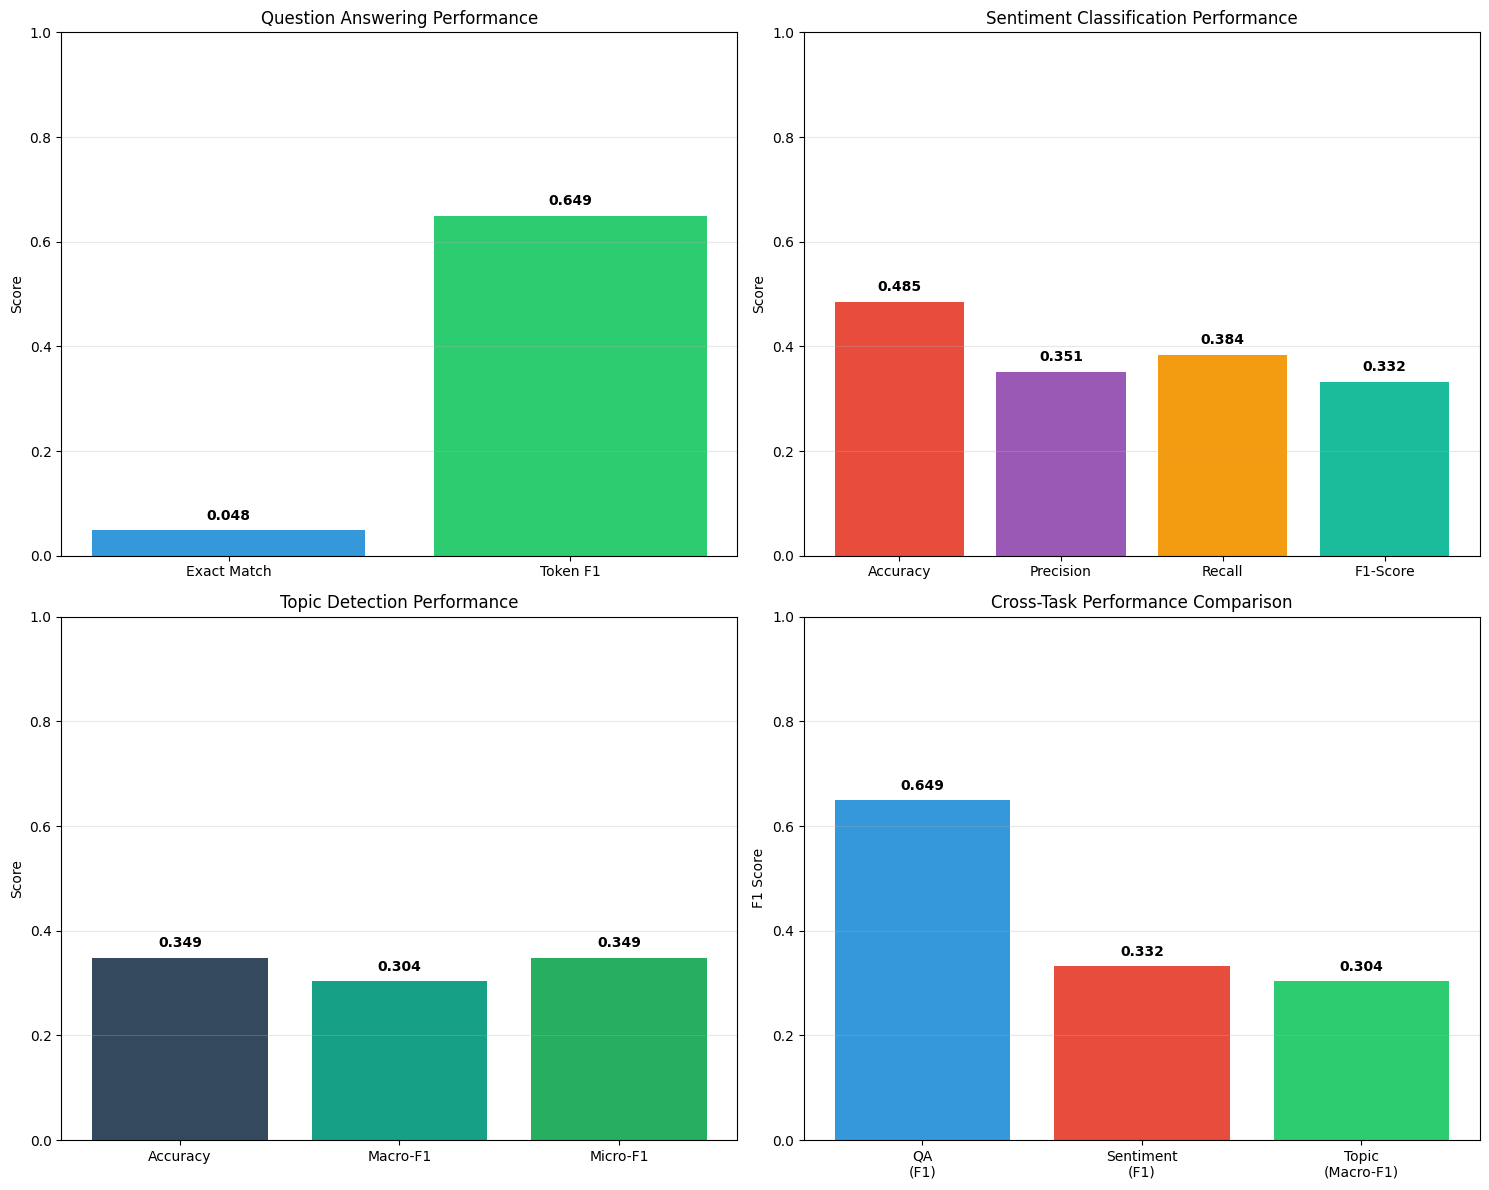

In [106]:
# ============================================================================
# 10. VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: QA Performance
ax1 = axes[0, 0]
qa_metrics = ['Exact Match', 'Token F1']
qa_scores = [np.mean(qa_em_scores), np.mean(qa_f1_scores)]
ax1.bar(qa_metrics, qa_scores, color=['#3498db', '#2ecc71'])
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_title('Question Answering Performance')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(qa_scores):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Sentiment Classification
ax2 = axes[0, 1]
sent_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
sent_scores = [sent_accuracy, sent_precision, sent_recall, sent_f1]
ax2.bar(sent_metrics, sent_scores, color=['#e74c3c', '#9b59b6', '#f39c12', '#1abc9c'])
ax2.set_ylim(0, 1)
ax2.set_ylabel('Score')
ax2.set_title('Sentiment Classification Performance')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(sent_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Topic Detection
ax3 = axes[1, 0]
topic_metrics = ['Accuracy', 'Macro-F1', 'Micro-F1']
topic_scores = [topic_accuracy, topic_macro_f1, topic_micro_f1]
ax3.bar(topic_metrics, topic_scores, color=['#34495e', '#16a085', '#27ae60'])
ax3.set_ylim(0, 1)
ax3.set_ylabel('Score')
ax3.set_title('Topic Detection Performance')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(topic_scores):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 4: Task Comparison
ax4 = axes[1, 1]
tasks = ['QA\n(F1)', 'Sentiment\n(F1)', 'Topic\n(Macro-F1)']
comparison_scores = [np.mean(qa_f1_scores), sent_f1, topic_macro_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax4.bar(tasks, comparison_scores, color=colors)
ax4.set_ylim(0, 1)
ax4.set_ylabel('F1 Score')
ax4.set_title('Cross-Task Performance Comparison')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_scores):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/financial_analysis_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualizations saved as 'financial_analysis_results.png'")
plt.show()

In [107]:
# ============================================================================
# 11. SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save detailed predictions
output_df = df[['question', 'answer', 'context',
                'qa_pred', 'qa_em', 'qa_f1',
                'sentiment_true', 'sentiment_pred',
                'topic_true', 'topic_pred']]
output_df.to_csv(f'{OUTPUT_PATH}/financial_analysis_predictions.csv', index=False)
print("✓ Detailed predictions saved to 'financial_analysis_predictions.csv'")

# Save summary results
results_summary.to_csv(f'{OUTPUT_PATH}/financial_analysis_summary.csv', index=False)
print("✓ Summary results saved to 'financial_analysis_summary.csv'")

print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("=" * 80)
print(f"\nModel: {MODEL_NAME}")
print(f"Prompting Strategy: Tree-of-Thought")
print(f"Total Records Processed: {len(df)}")
print(f"\nKey Findings:")
print(f"  • QA Token F1: {np.mean(qa_f1_scores):.3f}")
print(f"  • Sentiment F1: {sent_f1:.3f}")
print(f"  • Topic Macro-F1: {topic_macro_f1:.3f}")
print("=" * 80)


SAVING RESULTS
✓ Detailed predictions saved to 'financial_analysis_predictions.csv'
✓ Summary results saved to 'financial_analysis_summary.csv'

PIPELINE COMPLETED SUCCESSFULLY

Model: qwen/qwen3-32b
Prompting Strategy: Tree-of-Thought
Total Records Processed: 1675

Key Findings:
  • QA Token F1: 0.649
  • Sentiment F1: 0.332
  • Topic Macro-F1: 0.304


In [ ]:
# ============================================================================
# 12. EXPLAINABLE AI (XAI) - SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("EXPLAINABLE AI ANALYSIS")
print("=" * 80)

# ============================================================================
# 12.1 PREPARE SURROGATE MODEL FOR SENTIMENT
# ============================================================================

print("\n[1/4] Training surrogate model for Sentiment Classification...")

# Create TF-IDF features
tfidf_sent = TfidfVectorizer(max_features=100, ngram_range=(1, 2), lowercase=True, stop_words='english', dtype=float)
# X_sent = tfidf_sent.fit_transform(df['context'])
X_sent = tfidf_sent.fit_transform(df['context'])

# Train a surrogate Random Forest model
rf_sent = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_sent.fit(X_sent, df['sentiment_true'])

print(f"✓ Surrogate model trained (Accuracy: {rf_sent.score(X_sent, df['sentiment_true']):.3f})")


EXPLAINABLE AI ANALYSIS

[1/4] Training surrogate model for Sentiment Classification...
✓ Surrogate model trained (Accuracy: 0.728)


In [13]:
# ============================================================================
# 12.2 SHAP ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[2/4] Generating SHAP explanations for Sentiment...")

X_sent_dense = X_sent.toarray()

# Create SHAP explainer
explainer_sent = shap.TreeExplainer(rf_sent)
shap_values_sent = explainer_sent.shap_values(X_sent_dense)

# SHAP Summary Plot
fig_shap_sent, axes_shap = plt.subplots(1, 2, figsize=(18, 6))

# Plot for each sentiment class (assuming 3 classes: Negative=0, Neutral=1, Positive=2)
class_names_sent = ['Negative', 'Neutral', 'Positive']
feature_names_sent = tfidf_sent.get_feature_names_out()

shap_values_class_2 = shap_values_sent[:, :, 2]
# Summary plot for Positive class
if len(shap_values_sent) >= 3:
    plt.sca(axes_shap[0])
    shap_values_class_2 = shap_values_sent[:, :, 2]
    shap.summary_plot(shap_values_class_2, X_sent_dense,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[0].set_title('SHAP Feature Importance - Positive Sentiment', fontsize=14, fontweight='bold')

    # Summary plot for Negative class
    plt.sca(axes_shap[1])
    shap_values_negative = shap_values_sent[:, :, 0]
    shap.summary_plot(shap_values_negative, X_sent,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[1].set_title('SHAP Feature Importance - Negative Sentiment', fontsize=14, fontweight='bold')


[2/4] Generating SHAP explanations for Sentiment...



[2/4] Generating SHAP explanations for Sentiment...
✓ SHAP plots saved as 'xai_shap_sentiment.png'


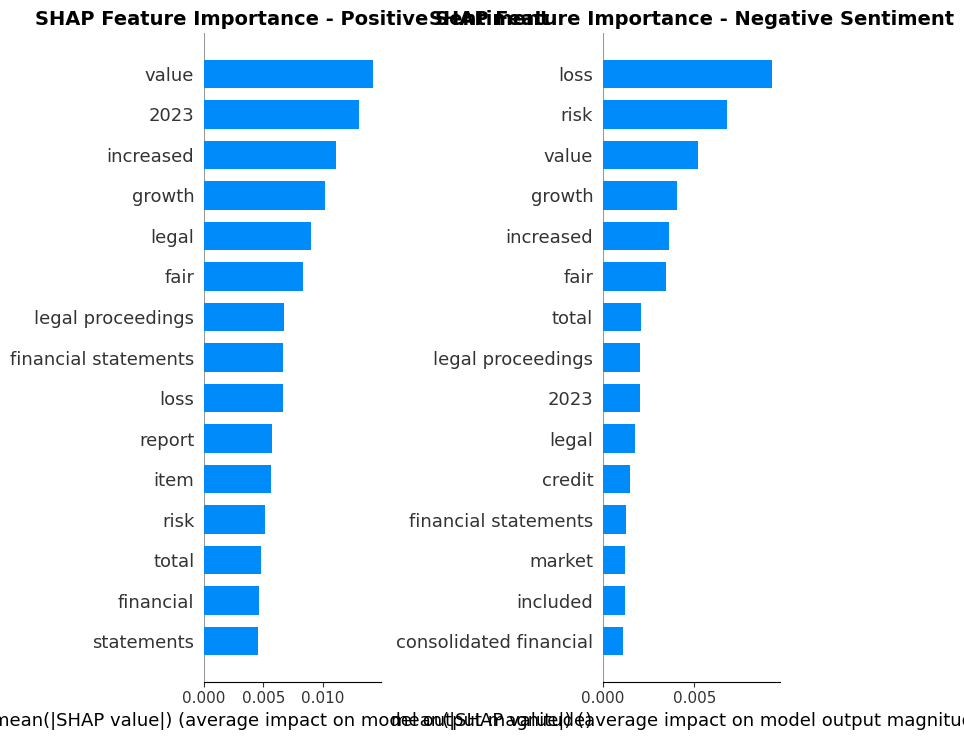

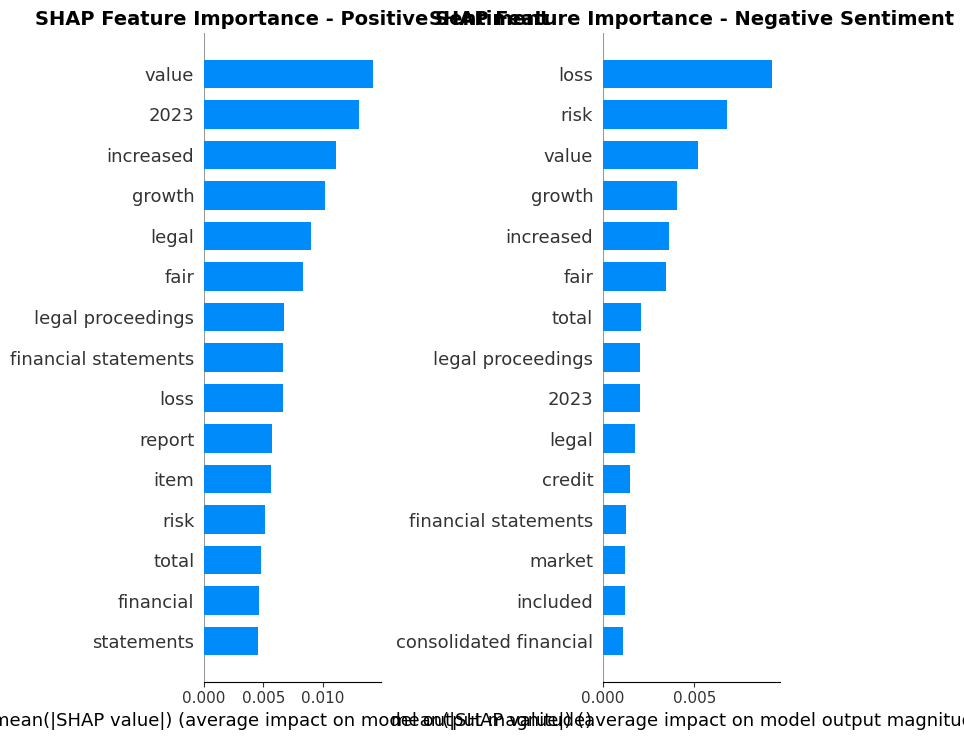


Generating SHAP force plot for sample prediction...


✓ SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'


<Figure size 1400x300 with 0 Axes>

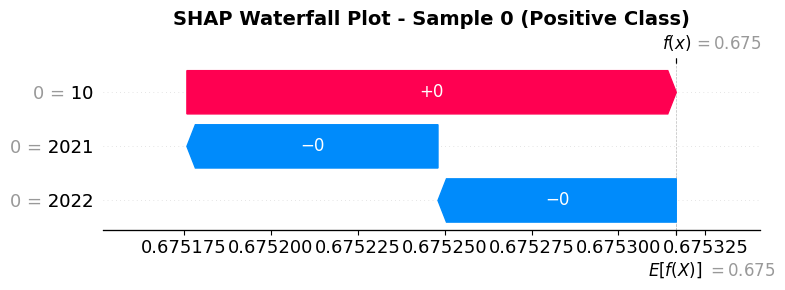

In [14]:
# ============================================================================
# 12.2 SHAP ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[2/4] Generating SHAP explanations for Sentiment...")

X_sent_dense = X_sent.toarray()

# Create SHAP explainer
explainer_sent = shap.TreeExplainer(rf_sent)
shap_values_sent = explainer_sent.shap_values(X_sent_dense)

# SHAP Summary Plot
fig_shap_sent, axes_shap = plt.subplots(1, 2, figsize=(18, 6))

# Plot for each sentiment class (assuming 3 classes: Negative=0, Neutral=1, Positive=2)
class_names_sent = ['Negative', 'Neutral', 'Positive']
feature_names_sent = tfidf_sent.get_feature_names_out()

shap_values_class_2 = shap_values_sent[:, :, 2]
# Summary plot for Positive class
if len(shap_values_sent) >= 3:
    plt.sca(axes_shap[0])
    shap_values_class_2 = shap_values_sent[:, :, 2]
    shap.summary_plot(shap_values_class_2, X_sent_dense,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[0].set_title('SHAP Feature Importance - Positive Sentiment', fontsize=14, fontweight='bold')

    # Summary plot for Negative class
    plt.sca(axes_shap[1])
    shap_values_negative = shap_values_sent[:, :, 0]
    shap.summary_plot(shap_values_negative, X_sent,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[1].set_title('SHAP Feature Importance - Negative Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
# fig_shap_sent.set_size_inches(24, 6)
plt.savefig(f'{OUTPUT_PATH}/xai_shap_sentiment.png', dpi=300, bbox_inches='tight')
print("✓ SHAP plots saved as 'xai_shap_sentiment.png'")
plt.show()

# SHAP Force Plot for a specific example
print("\nGenerating SHAP force plot for sample prediction...")
sample_idx = 0
shap.initjs()

# Individual SHAP explanation
if len(shap_values_sent) >= 3:
    fig_force = plt.figure(figsize=(14, 3))
    shap_explanation = shap.Explanation(
        values=shap_values_sent[2][sample_idx],
        base_values=explainer_sent.expected_value[2],
        data=X_sent[sample_idx].toarray()[0],
        feature_names=feature_names_sent
    )

    # Waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap_explanation, max_display=15, show=False)
    plt.title(f'SHAP Waterfall Plot - Sample {sample_idx} (Positive Class)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/xai_shap_waterfall_sentiment.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'")
    plt.show()


[3/4] Generating LIME explanations for Sentiment...
✓ LIME plots saved as 'xai_lime_sentiment.png'


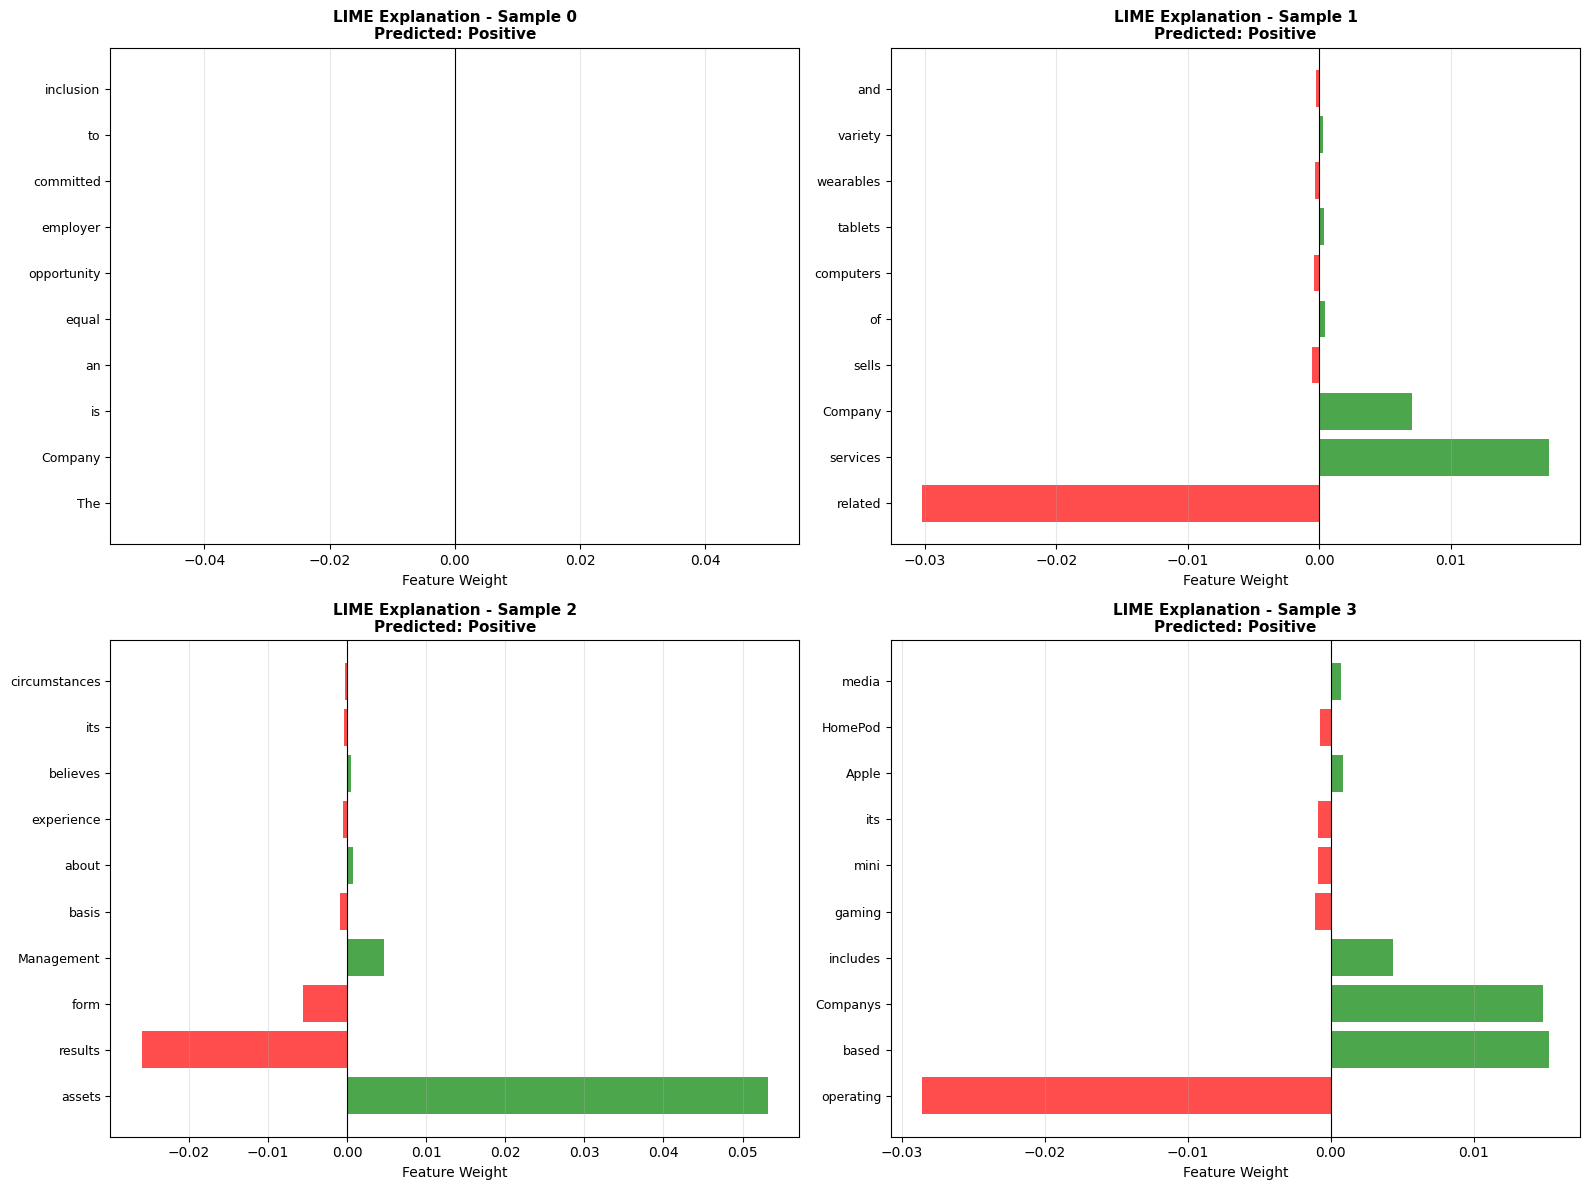

In [15]:
# ============================================================================
# 12.3 LIME ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[3/4] Generating LIME explanations for Sentiment...")

# Create LIME explainer
def sentiment_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_sent.transform(texts)
    return rf_sent.predict_proba(X)

lime_sent = LimeTextExplainer(class_names=class_names_sent)

# Generate LIME explanation for sample instances
lime_explanations_sent = []
fig_lime_sent, axes_lime = plt.subplots(2, 2, figsize=(16, 12))
axes_lime = axes_lime.flatten()

for idx in range(min(4, len(df))):
    exp = lime_sent.explain_instance(
        df.iloc[idx]['context'],
        sentiment_predictor,
        num_features=10,
        top_labels=1
    )
    lime_explanations_sent.append(exp)

    # Plot explanation
    fig_temp = exp.as_pyplot_figure(label=exp.top_labels[0])

    # Transfer to subplot
    ax = axes_lime[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted: {class_names_sent[exp.top_labels[0]]}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

    plt.close(fig_temp)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_sentiment.png', dpi=300, bbox_inches='tight')
print("✓ LIME plots saved as 'xai_lime_sentiment.png'")
plt.show()

In [16]:
# ============================================================================
# 12.4 PREPARE SURROGATE MODEL FOR TOPIC DETECTION
# ============================================================================

print("\n[4/4] Training surrogate model for Topic Detection...")

# Create TF-IDF features for topics
tfidf_topic = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_topic = tfidf_topic.fit_transform(df['question'])

# Train a surrogate Random Forest model
rf_topic = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_topic.fit(X_topic, df['topic_true'])

print(f"✓ Surrogate model trained (Accuracy: {rf_topic.score(X_topic, df['topic_true']):.3f})")


[4/4] Training surrogate model for Topic Detection...
✓ Surrogate model trained (Accuracy: 0.894)



Generating SHAP explanations for Topic Detection...
✓ SHAP topic plots saved as 'xai_shap_topic.png'


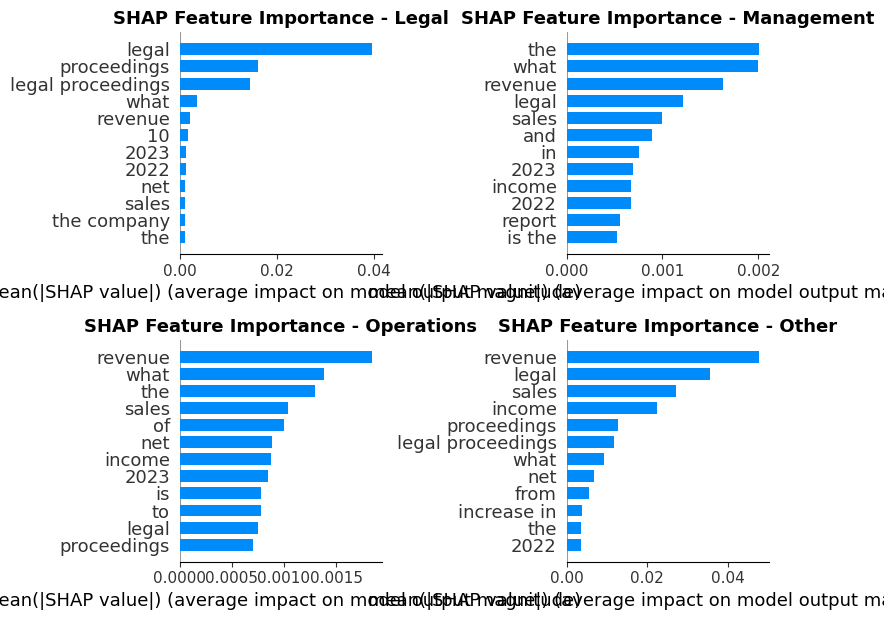

In [17]:
# ============================================================================
# 12.5 SHAP ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating SHAP explanations for Topic Detection...")

X_topic_dense = X_topic.toarray()

# Create SHAP explainer
explainer_topic = shap.TreeExplainer(rf_topic)
shap_values_topic = explainer_topic.shap_values(X_topic_dense)

# SHAP Summary Plot for Topics
fig_shap_topic, axes_shap_topic = plt.subplots(2, 2, figsize=(18, 12))
axes_shap_topic = axes_shap_topic.flatten()

# Get unique topics and their indices
unique_topics = rf_topic.classes_
feature_names_topic = tfidf_topic.get_feature_names_out()

for i, topic in enumerate(unique_topics[:4]):  # Show first 4 topics
    if i < len(shap_values_topic):
        plt.sca(axes_shap_topic[i])
        shap_values_class_i = shap_values_topic[:, :, i]
        shap.summary_plot(shap_values_class_i, X_topic,
                         feature_names=feature_names_topic,
                         plot_type="bar", show=False, max_display=12)
        axes_shap_topic[i].set_title(f'SHAP Feature Importance - {topic}',
                                     fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_shap_topic.png', dpi=300, bbox_inches='tight')
print("✓ SHAP topic plots saved as 'xai_shap_topic.png'")
plt.show()


Generating LIME explanations for Topic Detection...
✓ LIME topic plots saved as 'xai_lime_topic.png'


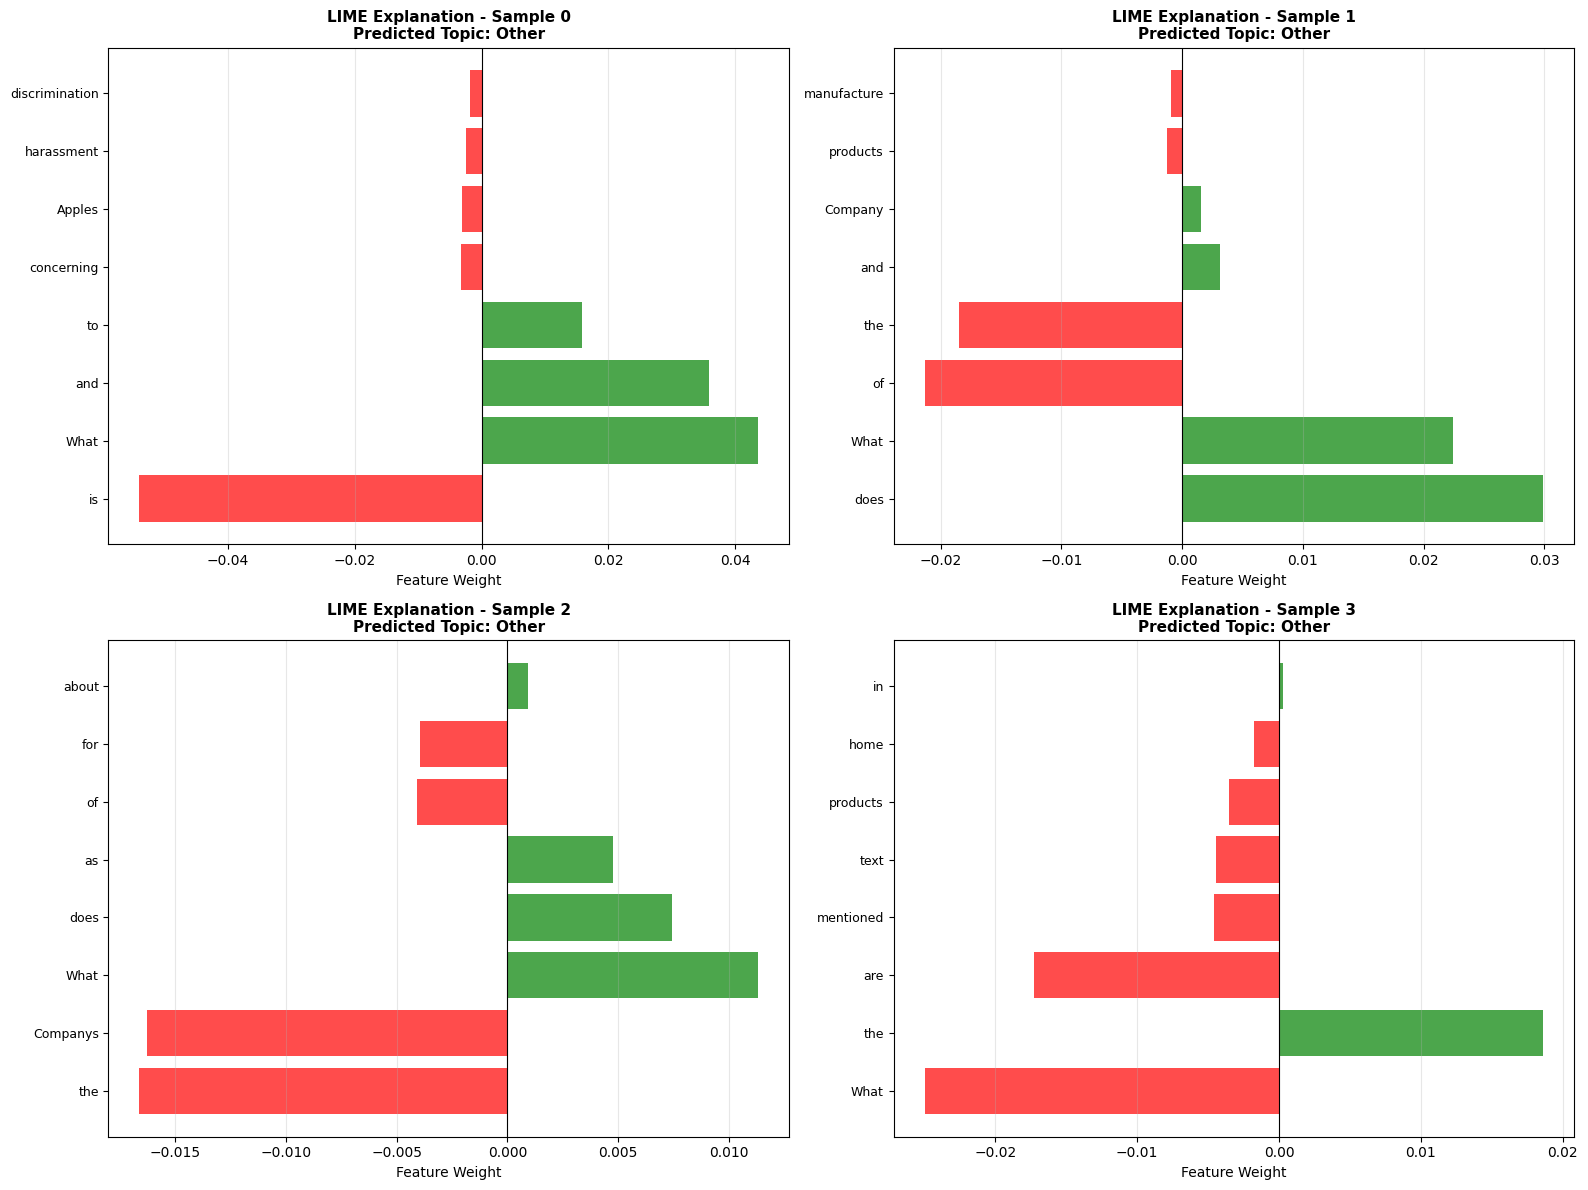

In [18]:
# ============================================================================
# 12.6 LIME ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating LIME explanations for Topic Detection...")

# Create LIME explainer for topics
def topic_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_topic.transform(texts)
    return rf_topic.predict_proba(X)

lime_topic = LimeTextExplainer(class_names=unique_topics.tolist())

# Generate LIME explanation for sample instances
fig_lime_topic, axes_lime_topic = plt.subplots(2, 2, figsize=(16, 12))
axes_lime_topic = axes_lime_topic.flatten()

for idx in range(min(4, len(df))):
    exp = lime_topic.explain_instance(
        df.iloc[idx]['question'],
        topic_predictor,
        num_features=8,
        top_labels=1
    )

    # Plot explanation
    ax = axes_lime_topic[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    pred_topic = unique_topics[exp.top_labels[0]]
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted Topic: {pred_topic}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_topic.png', dpi=300, bbox_inches='tight')
print("✓ LIME topic plots saved as 'xai_lime_topic.png'")
plt.show()


Generating Feature Importance Comparison...
✓ Feature importance plots saved as 'xai_feature_importance.png'


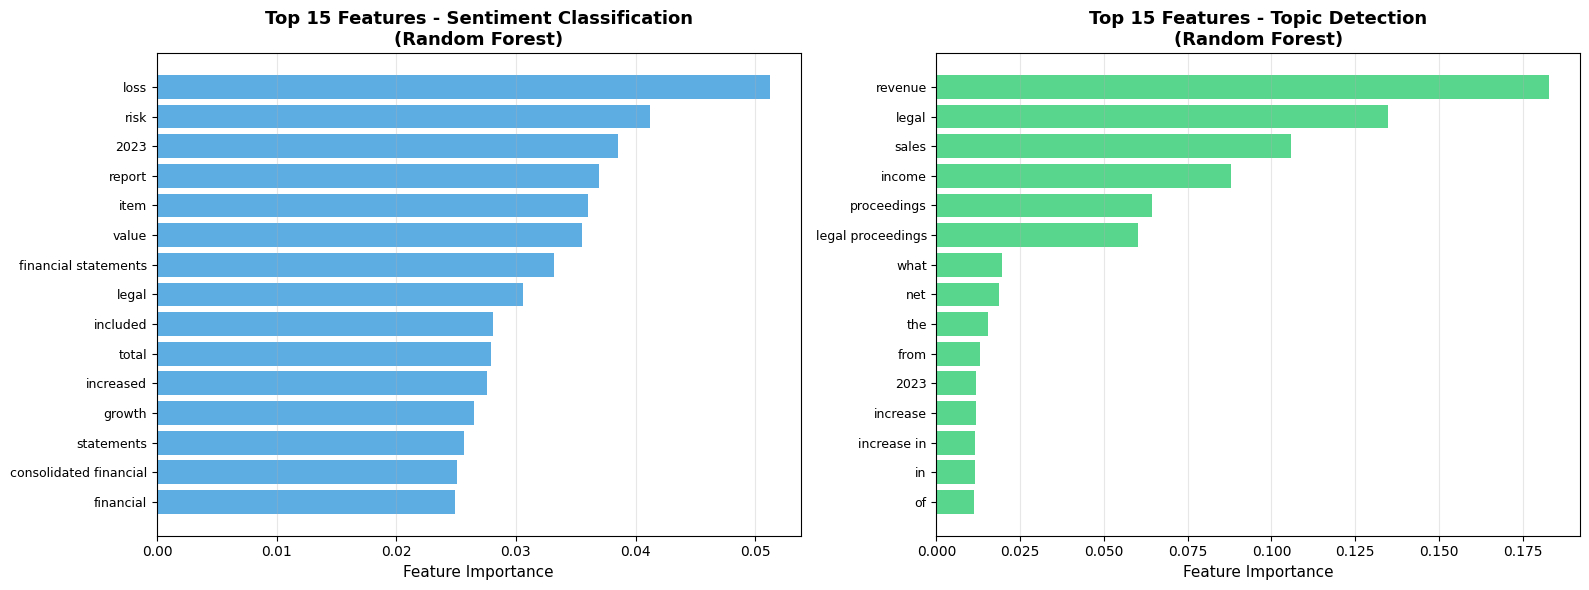

In [19]:
# ============================================================================
# 12.7 FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\nGenerating Feature Importance Comparison...")

fig_importance, axes_imp = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment Feature Importance
feature_importance_sent = rf_sent.feature_importances_
top_n = 15
indices_sent = np.argsort(feature_importance_sent)[-top_n:]
top_features_sent = [feature_names_sent[i] for i in indices_sent]
top_importance_sent = feature_importance_sent[indices_sent]

axes_imp[0].barh(range(top_n), top_importance_sent, color='#3498db', alpha=0.8)
axes_imp[0].set_yticks(range(top_n))
axes_imp[0].set_yticklabels(top_features_sent, fontsize=9)
axes_imp[0].set_xlabel('Feature Importance', fontsize=11)
axes_imp[0].set_title('Top 15 Features - Sentiment Classification\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[0].grid(axis='x', alpha=0.3)

# Topic Feature Importance
feature_importance_topic = rf_topic.feature_importances_
indices_topic = np.argsort(feature_importance_topic)[-top_n:]
top_features_topic = [feature_names_topic[i] for i in indices_topic]
top_importance_topic = feature_importance_topic[indices_topic]

axes_imp[1].barh(range(top_n), top_importance_topic, color='#2ecc71', alpha=0.8)
axes_imp[1].set_yticks(range(top_n))
axes_imp[1].set_yticklabels(top_features_topic, fontsize=9)
axes_imp[1].set_xlabel('Feature Importance', fontsize=11)
axes_imp[1].set_title('Top 15 Features - Topic Detection\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plots saved as 'xai_feature_importance.png'")
plt.show()

In [20]:
# ============================================================================
# 12.8 XAI METRICS AND SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("XAI ANALYSIS SUMMARY")
print("=" * 80)

# Calculate explainability metrics
xai_metrics = {
    'Task': [],
    'Surrogate Model Accuracy': [],
    'Top Feature': [],
    'Feature Importance': []
}

# Sentiment XAI metrics
xai_metrics['Task'].append('Sentiment Classification')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_sent.score(X_sent, df['sentiment_true']):.4f}")
top_sent_idx = np.argmax(feature_importance_sent)
xai_metrics['Top Feature'].append(feature_names_sent[top_sent_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_sent[top_sent_idx]:.4f}")

# Topic XAI metrics
xai_metrics['Task'].append('Topic Detection')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_topic.score(X_topic, df['topic_true']):.4f}")
top_topic_idx = np.argmax(feature_importance_topic)
xai_metrics['Top Feature'].append(feature_names_topic[top_topic_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_topic[top_topic_idx]:.4f}")

xai_summary_df = pd.DataFrame(xai_metrics)
print("\n", xai_summary_df.to_string(index=False))

# Save XAI summary
xai_summary_df.to_csv(f'{OUTPUT_PATH}/xai_analysis_summary.csv', index=False)
print("\n✓ XAI summary saved to 'xai_analysis_summary.csv'")


XAI ANALYSIS SUMMARY

                     Task Surrogate Model Accuracy Top Feature Feature Importance
Sentiment Classification                   0.7282        loss             0.0512
         Topic Detection                   0.8937     revenue             0.1830

✓ XAI summary saved to 'xai_analysis_summary.csv'


In [21]:
# ============================================================================
# 12.9 DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
# ============================================================================

print("\n" + "-" * 80)
print("DETAILED XAI EXPLANATIONS FOR KEY INSTANCES")
print("-" * 80)

# Select one instance from each task for detailed explanation
sample_idx_detailed = 0

print(f"\n📋 Sample {sample_idx_detailed} - Detailed Analysis")
print("-" * 80)

# Original data
print(f"\nOriginal Context: {df.iloc[sample_idx_detailed]['context'][:200]}...")
print(f"True Sentiment: {df.iloc[sample_idx_detailed]['sentiment_true']}")
print(f"Predicted Sentiment: {df.iloc[sample_idx_detailed]['sentiment_pred']}")

# SHAP values for this instance
if len(shap_values_sent) >= 3:
    print(f"\nTop 5 SHAP Features (Sentiment):")
    shap_instance = shap_values_sent[2][sample_idx_detailed]  # Positive class
    top_shap_indices = np.argsort(np.abs(shap_instance))[-5:][::-1]
    for i, idx in enumerate(top_shap_indices, 1):
        print(f"  {i}. {feature_names_sent[idx]}: {shap_instance[idx]:.4f}")

# LIME explanation
print(f"\nLIME Explanation (Sentiment):")
lime_exp_detailed = lime_explanations_sent[sample_idx_detailed]
for feat, weight in lime_exp_detailed.as_list(label=lime_exp_detailed.top_labels[0])[:5]:
    print(f"  '{feat}': {weight:.4f}")

print("\n" + "=" * 80)
print("XAI ANALYSIS COMPLETED")
print("=" * 80)
print("\n✓ Generated Visualizations:")
print("  1. xai_shap_sentiment.png - SHAP feature importance for sentiment")
print("  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot")
print("  3. xai_lime_sentiment.png - LIME explanations for sentiment")
print("  4. xai_shap_topic.png - SHAP feature importance for topics")
print("  5. xai_lime_topic.png - LIME explanations for topics")
print("  6. xai_feature_importance.png - Feature importance comparison")
print("\n✓ Saved Reports:")
print("  1. xai_analysis_summary.csv - XAI metrics summary")

print("\n" + "=" * 80)
print("COMPLETE PIPELINE FINISHED")
print("=" * 80)


--------------------------------------------------------------------------------
DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
--------------------------------------------------------------------------------

📋 Sample 0 - Detailed Analysis
--------------------------------------------------------------------------------

Original Context: The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination....
True Sentiment: Positive
Predicted Sentiment: Positive

Top 5 SHAP Features (Sentiment):
  1. 10: 0.0001
  2. 2021: -0.0001
  3. 2022: -0.0001

LIME Explanation (Sentiment):
  'The': 0.0000
  'Company': 0.0000
  'is': 0.0000
  'an': 0.0000
  'equal': 0.0000

XAI ANALYSIS COMPLETED

✓ Generated Visualizations:
  1. xai_shap_sentiment.png - SHAP feature importance for sentiment
  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot
  3. xai_lime_sentiment.png - LIME explanations for sentiment
  4. xai